# Chapter 13: Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(rstan)
library(rstanarm)
library(broom.mixed)
library(tidybayes)
library(ggmosaic)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recomp

## Exercise 13.6

In [2]:
head( hotel_bookings )

hotel        is_canceled lead_time arrival_date_year arrival_date_month
1 City Hotel   1             1       2015              September         
2 Resort Hotel 1            19       2016              March             
3 Resort Hotel 0             9       2017              August            
4 Resort Hotel 0           110       2016              November          
5 City Hotel   0           329       2017              July              
6 Resort Hotel 0           212       2017              August            
  arrival_date_week_number arrival_date_day_of_month stays_in_weekend_nights
1 40                       30                        0                      
2 12                       19                        2                      
3 31                        1                        0                      
4 46                       11                        0                      
5 30                       27                        0                      
6 35                       31                        2                      
  stays_in_week_nights adults ⋯ deposit_type agent company days_in_waiting_list
1 2                    1      ⋯ Non Refund   50    NULL    0                   
2 4                    2      ⋯ No Deposit   240   NULL    0                   
3 4                    2      ⋯ No Deposit   241   NULL    0                   
4 1                    2      ⋯ No Deposit   314   NULL    0                   
5 2                    2      ⋯ No Deposit   9     NULL    0                   
6 8                    2      ⋯ No Deposit   143   NULL    0                   
  customer_type average_daily_rate required_car_parking_spaces
1 Transient      98.10             0                          
2 Transient      70.17             0                          
3 Transient     193.40             0                          
4 Transient      36.24             1                          
5 Transient      89.10             0                          
6 Transient      89.75             0                          
  total_of_special_requests reservation_status reservation_status_date
1 0                         Canceled           2015-09-29             
2 1                         Canceled           2016-03-02             
3 1                         Check-Out          2017-08-05             
4 0                         Check-Out          2016-11-12             
5 1                         Check-Out          2017-07-29             
6 0                         Check-Out          2017-09-10

### a)

In [3]:
mean( hotel_bookings$is_canceled == '1' )

[1] 0.366

37% of bookings are canceled. This is a lot!

### b)

Compute means per class:

In [4]:
hotel_bookings %>% 
    select( is_canceled, lead_time, previous_cancellations, is_repeated_guest, average_daily_rate ) %>% 
    group_by( is_canceled ) %>% 
    summarise_all( list(mean=mean, sd=sd) )

is_canceled lead_time_mean previous_cancellations_mean is_repeated_guest_mean
1 0            83.45899      0.007886435                 0.03943218            
2 1           142.49180      0.267759563                 0.01912568            
  average_daily_rate_mean lead_time_sd previous_cancellations_sd
1  97.86945                93.90104    0.1636886                
2 106.99902               116.21010    1.9029606                
  is_repeated_guest_sd average_daily_rate_sd
1 0.1947745            46.75579             
2 0.1371542            43.31366

From a comparison of mean differences and standard deviations, no strong separations of density plots are expected.

#### Lead time

Linear scale:

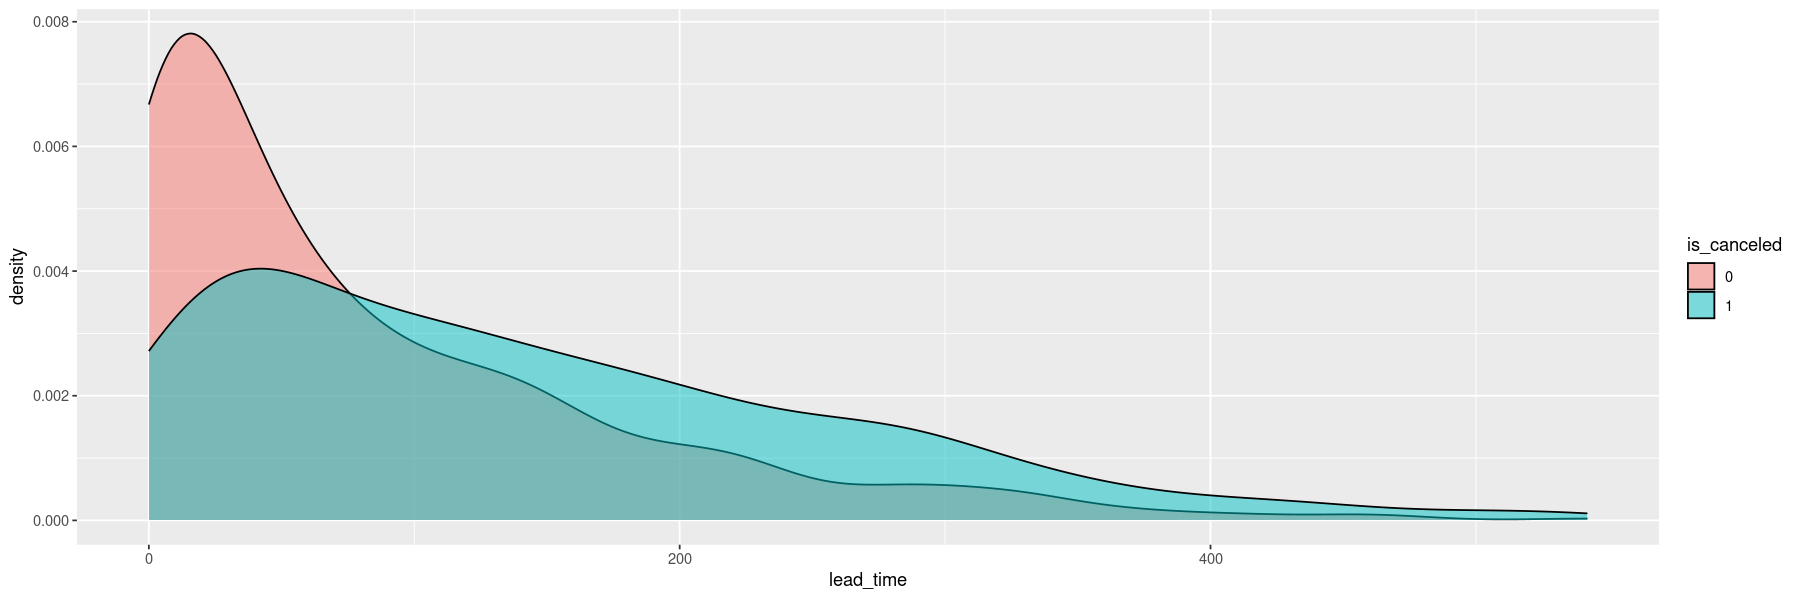

In [5]:
options(repr.plot.width=15, repr.plot.height=5)
plot <- ggplot( hotel_bookings, aes(x=lead_time, fill=is_canceled)) + geom_density( alpha=0.5 ) 
plot

Log scale:

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 44 rows containing non-finite values (`stat_density()`).”


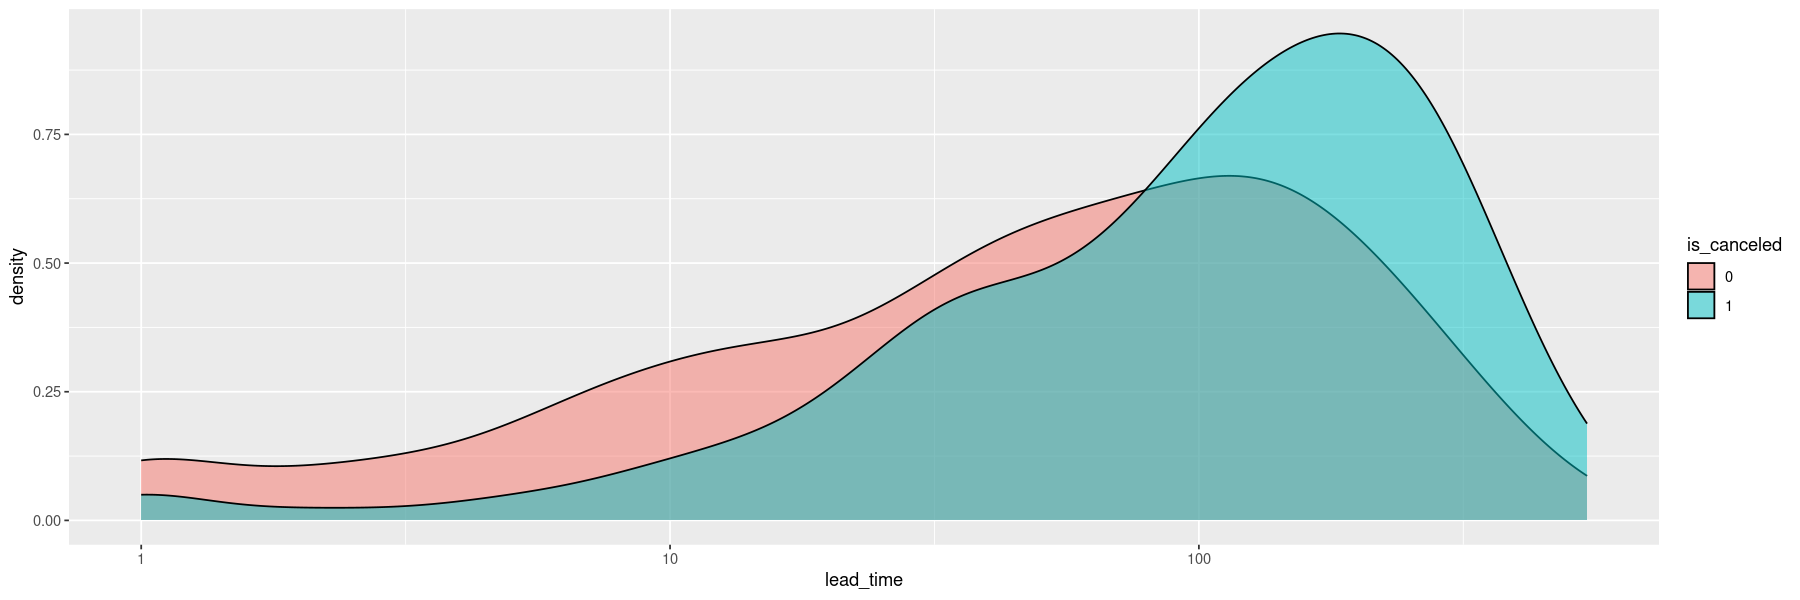

In [6]:
plot + scale_x_log10()

Boxplot:

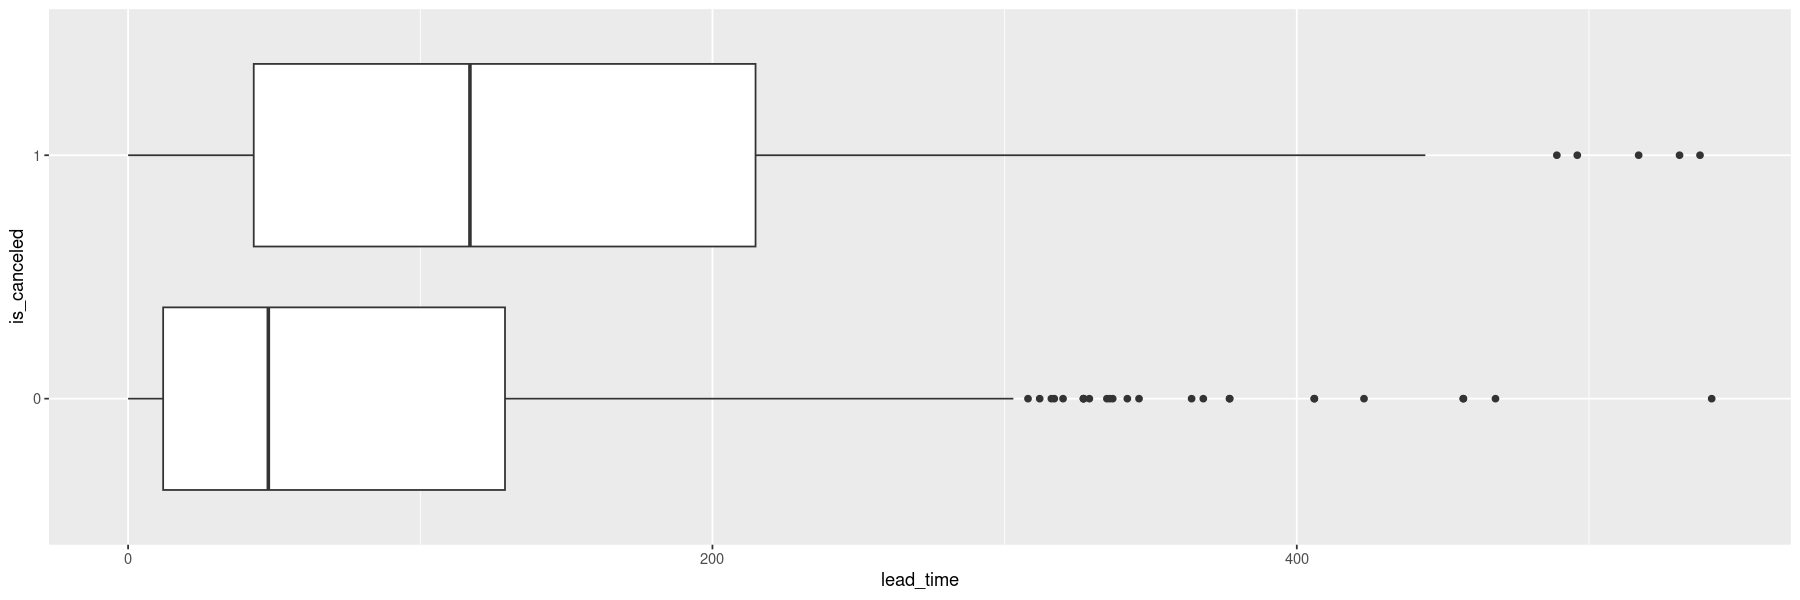

In [7]:
ggplot( hotel_bookings, aes(x=lead_time, y=is_canceled) ) + geom_boxplot()

It appears that the longer the room is booked in advanced, the larger the probability of cancelation. This makes sense, if one books only 1-2 weeks before, then one is typically sure that everything will work out.

#### Previous cancellations

Check distribution of previous cancellations:

In [8]:
hotel_bookings %>% 
    group_by( previous_cancellations ) %>% 
    summarise( n=n() )

previous_cancellations n  
1  0                     949
2  1                      48
3  4                       1
4 25                       1
5 26                       1

Most of the guests did not cancel previously. Considering the actual number of previous cancellations might lead to severe overfitting. As an alternative, one could include a binary variable 'has_canceled_previously'.

Density plot:

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 949 rows containing non-finite values (`stat_density()`).”


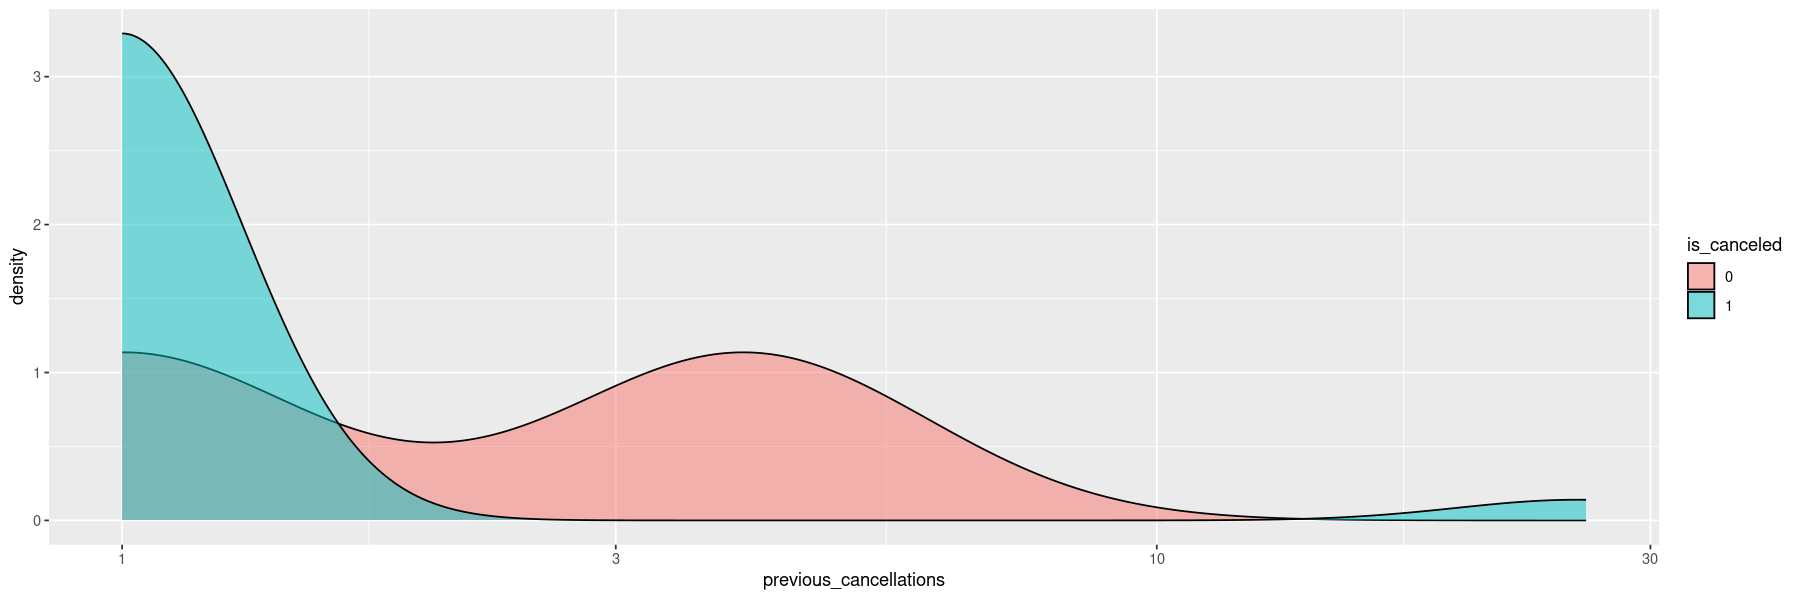

In [9]:
ggplot( hotel_bookings, aes(x=previous_cancellations, fill=is_canceled)) + 
    geom_density( alpha=0.5 ) + 
    scale_x_log10()

This is a dangerous visualisation and it is clearly visible that the data are sparse.

Mosaic plot:

Warning message:
“`unite_()` was deprecated in tidyr 1.2.0.
ℹ Please use `unite()` instead.
ℹ The deprecated feature was likely used in the ggmosaic package.
  Please report the issue at <https://github.com/haleyjeppson/ggmosaic>.”


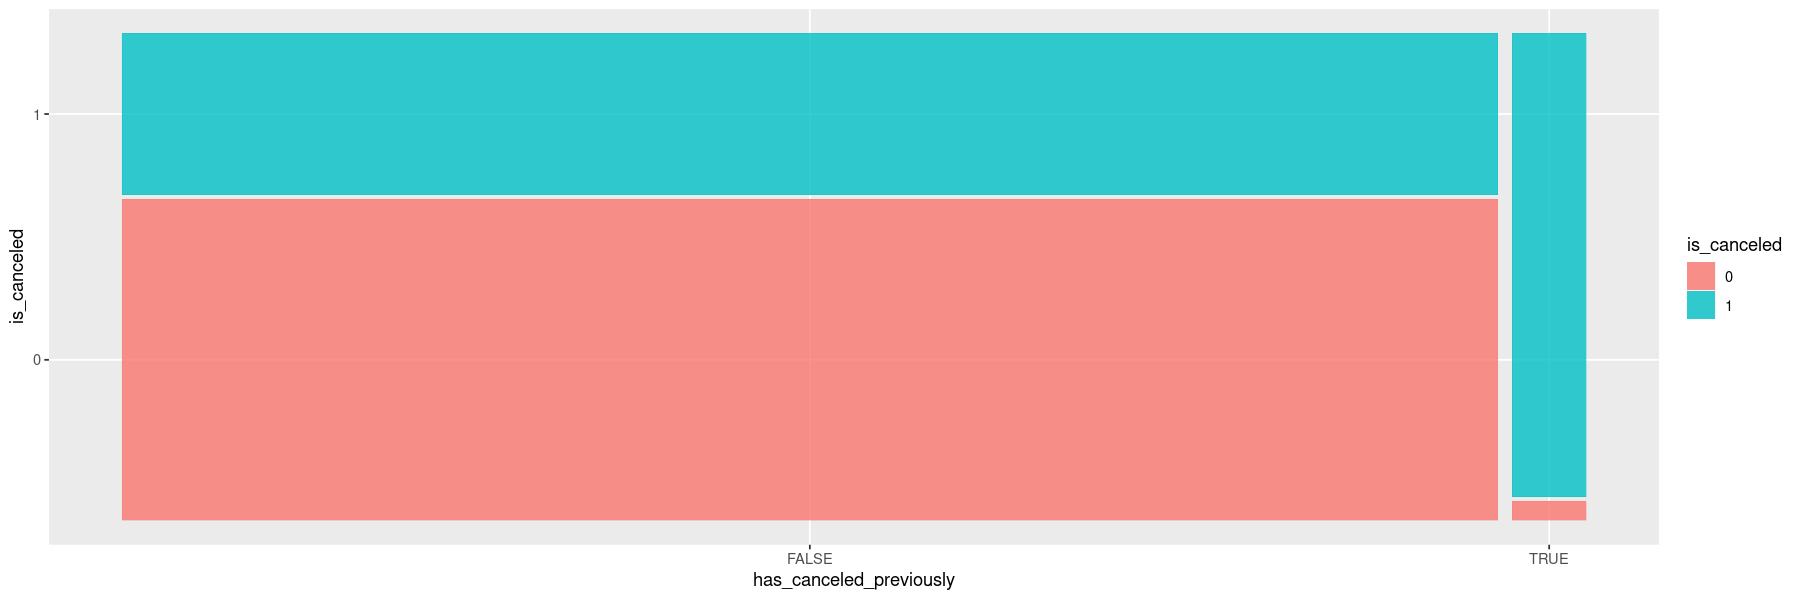

In [10]:
ggplot( data=hotel_bookings %>% mutate(has_canceled_previously=previous_cancellations>0) ) + 
    geom_mosaic( aes(x=product(is_canceled, has_canceled_previously), fill=is_canceled) )

It appears that a previous cancellation is an indicator for a cancellation now.

Table:

In [11]:
hotel_bookings %>% 
    group_by( is_canceled, previous_cancellations>0 ) %>% 
    summarise( n=n() )

`summarise()` has grouped output by 'is_canceled'. You can override using the
`.groups` argument.


is_canceled previous_cancellations > 0 n  
1 0           FALSE                      632
2 0            TRUE                        2
3 1           FALSE                      317
4 1            TRUE                       49

#### Repeated guests

Mosaic plot:

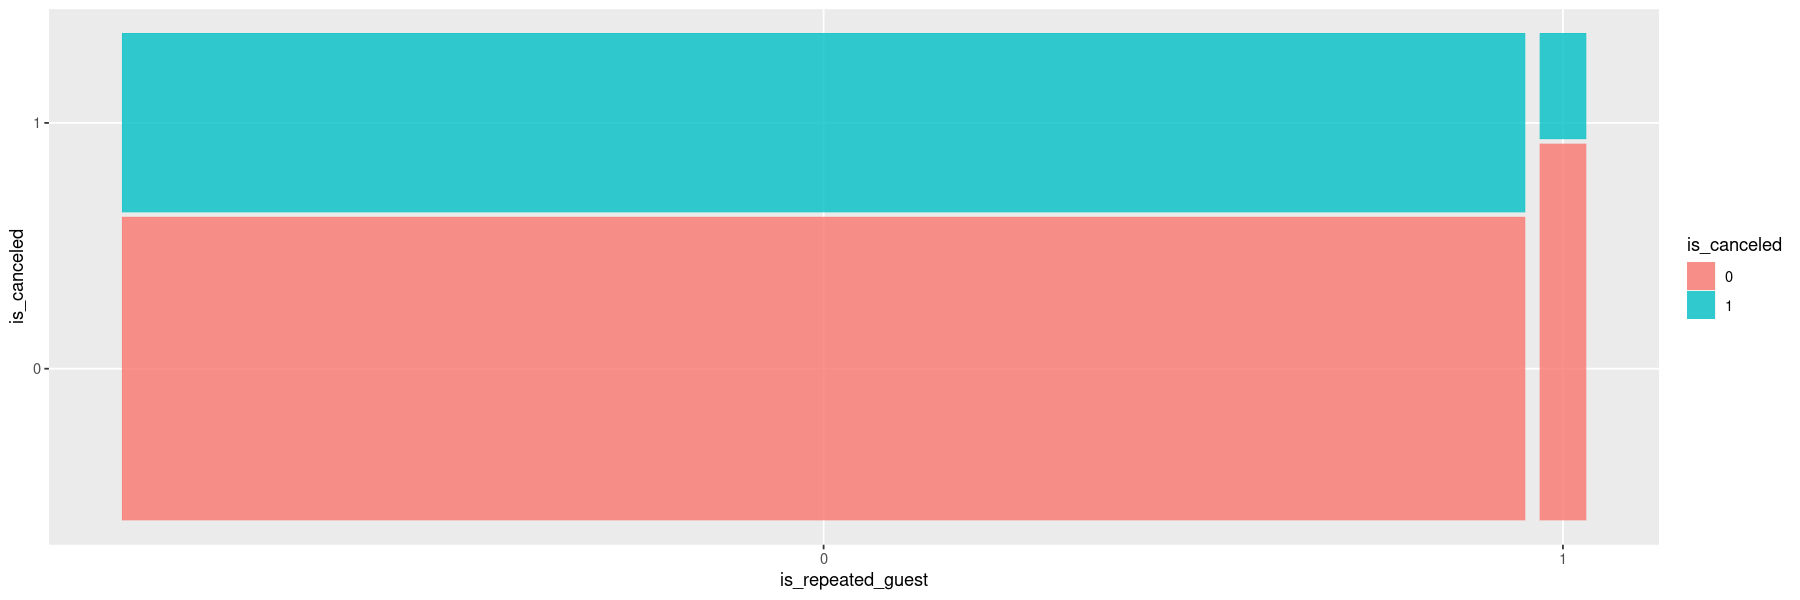

In [12]:
ggplot( data=hotel_bookings ) + geom_mosaic( aes(x=product(is_canceled, is_repeated_guest), fill=is_canceled) )

Table:

In [13]:
hotel_bookings %>% 
    group_by( is_canceled, is_repeated_guest ) %>% 
    summarise( n=n() )

`summarise()` has grouped output by 'is_canceled'. You can override using the
`.groups` argument.


is_canceled is_repeated_guest n  
1 0           0                 609
2 0           1                  25
3 1           0                 359
4 1           1                   7

Of the few repeated guests, slightly less appear to cancel their reservation, however the numbers are too low for a clear answer. There is also the risk for overfitting to the small number here.

#### Average daily rate

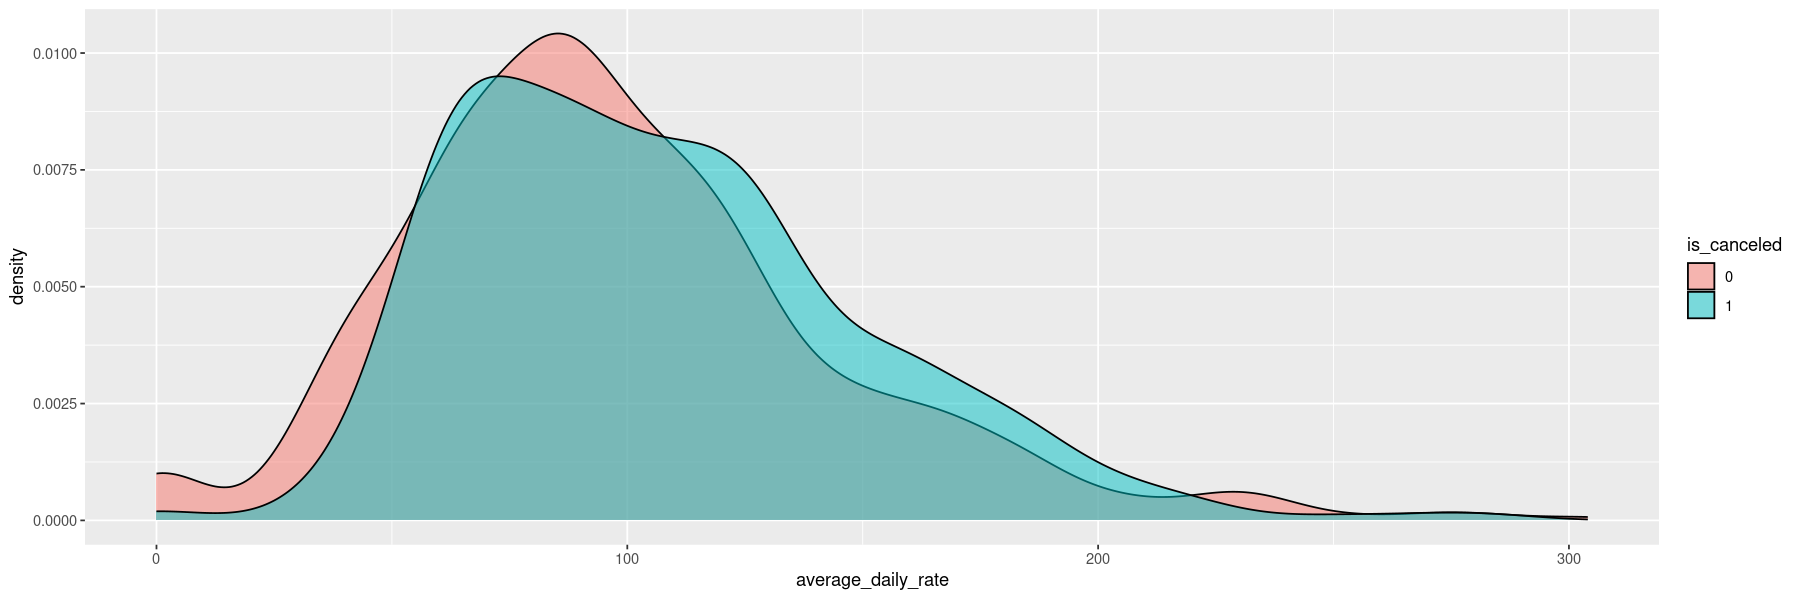

In [14]:
ggplot( hotel_bookings, aes(x=average_daily_rate, fill=is_canceled)) + geom_density( alpha=0.5 ) 

The differences appear to be small and probably not significant. At least there is no clear pattern that emerges.

### c)

Prior on intercept: Reasonable range for $\pi$ between 0.1 and 0.8, centered at 0.4. In terms of log-odds:

In [15]:
log(0.4/(1-0.4))

[1] -0.4054651

A probability of 0.1 corresponds to a log-odds of $\approx -2$ and 0.8 to a log-odds of $\approx 1.4$.

In [16]:
log(0.1/(1-0.1))

[1] -2.197225

In [17]:
log(0.8/(1-0.8))

[1] 1.386294

This can be more or less reproduced with a Gaussian prior centered around -0.4 with a standard deviation of 0.8:

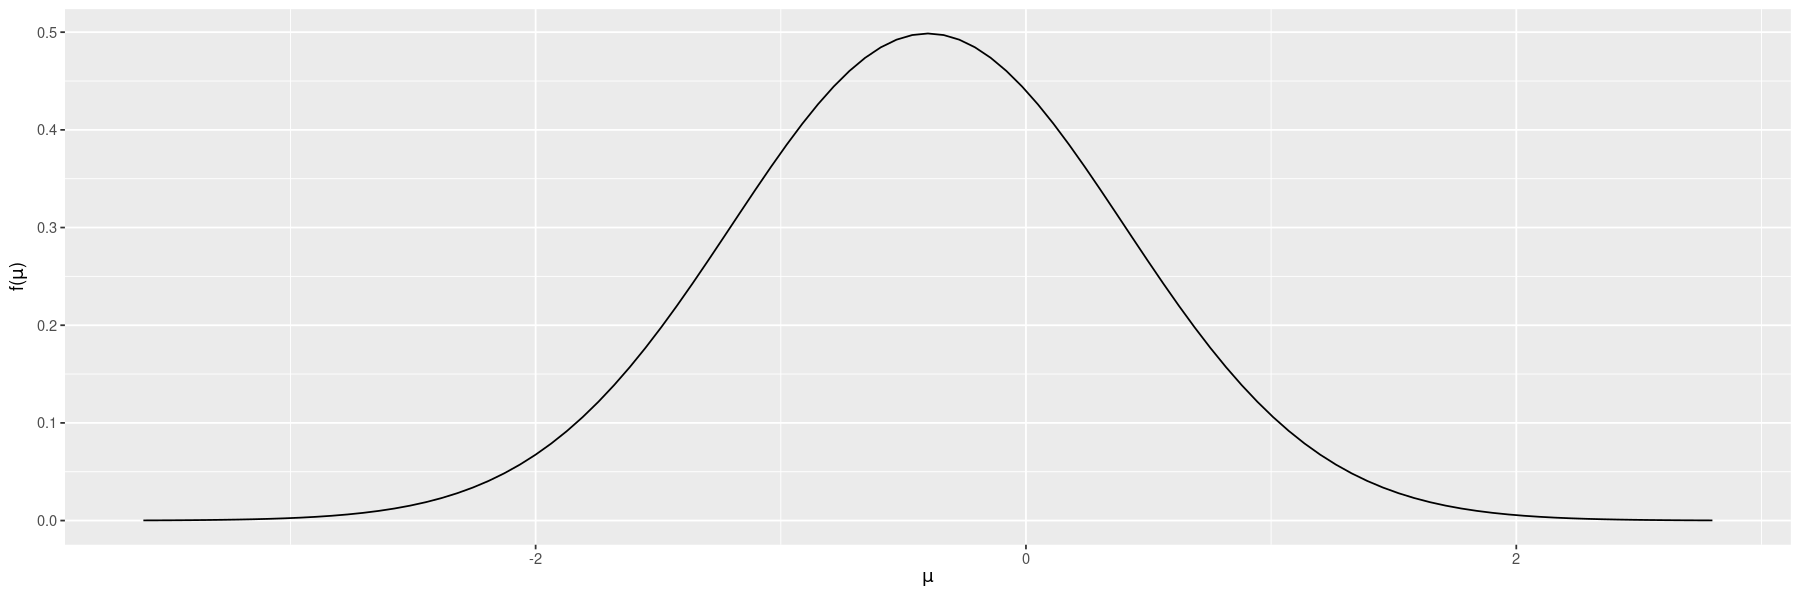

In [18]:
plot_normal( mean=-0.4, sd=0.8 )

Resulting model:

$$Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\beta_4 \sim \text{Bern}(\pi_i), \quad \log\left(\frac{\pi_i}{1-\pi_i}\right) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \beta_3 X_{3i} + \beta_4 X_{4i} $$

$$\beta_0 \sim N(0.4,0.8)$$
$$\beta_1 \sim N(0,\cdot)$$
$$\beta_2 \sim N(0,\cdot)$$
$$\beta_3 \sim N(0,\cdot)$$
$$\beta_4 \sim N(0,\cdot)$$

where $\cdot$ stands for `autoscale=TRUE` (weakly informed prior).

### d)

Since the outcome is of (binary) categorical nature, it is best modeled with a Bernoulli distribution. The parameter $\pi$ of the distribution needs to be modeled as a probablity in the interval [0,1], what is done best with a sigmoid function or equally by modeling the log-odds with a linear ansatz. Since $\beta_1$, ..,  $\beta_4$ are again parameters of a linear model, we can assume Gaussian priors as usual.

## Exercise 13.7

### a)

Simulate the model:

In [19]:
booking_model_1 <- stan_glm( is_canceled ~ lead_time + previous_cancellations + is_repeated_guest + average_daily_rate,
                             data = hotel_bookings, family = binomial,
                             prior_intercept = normal(0.4, 0.8),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.554266 seconds (Warm-up)
Chain 1:                0.611307 seconds (Sampling)
Chain 1:  

Prior summary:

In [20]:
prior_summary( booking_model_1 )

Priors for model 'booking_model_1' 
------
Intercept (after predictors centered)
 ~ normal(location = 0.4, scale = 0.8)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [1,1,1,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [0.0094,0.8588,5.6790,...])
------
See help('prior_summary.stanreg') for more details

Diagnostics:

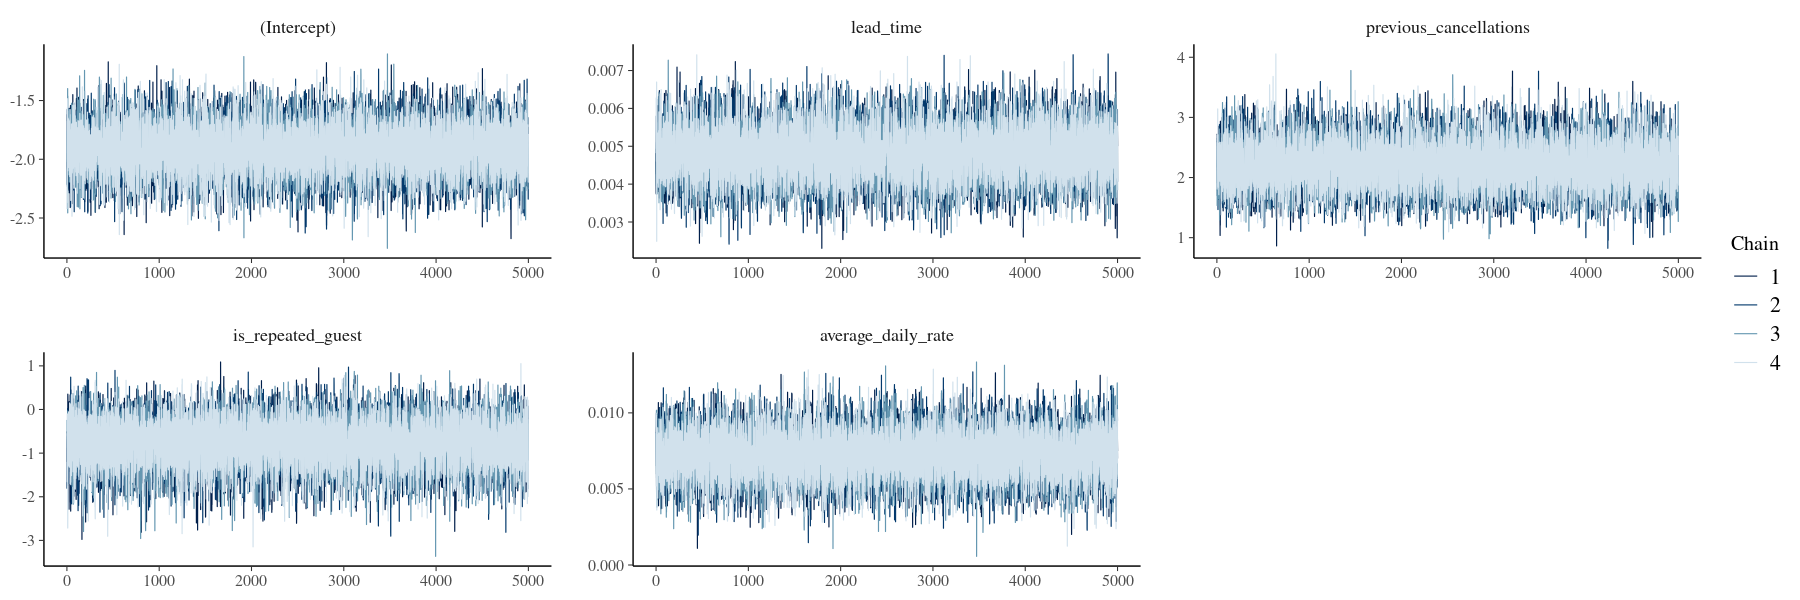

In [21]:
mcmc_trace( booking_model_1 )

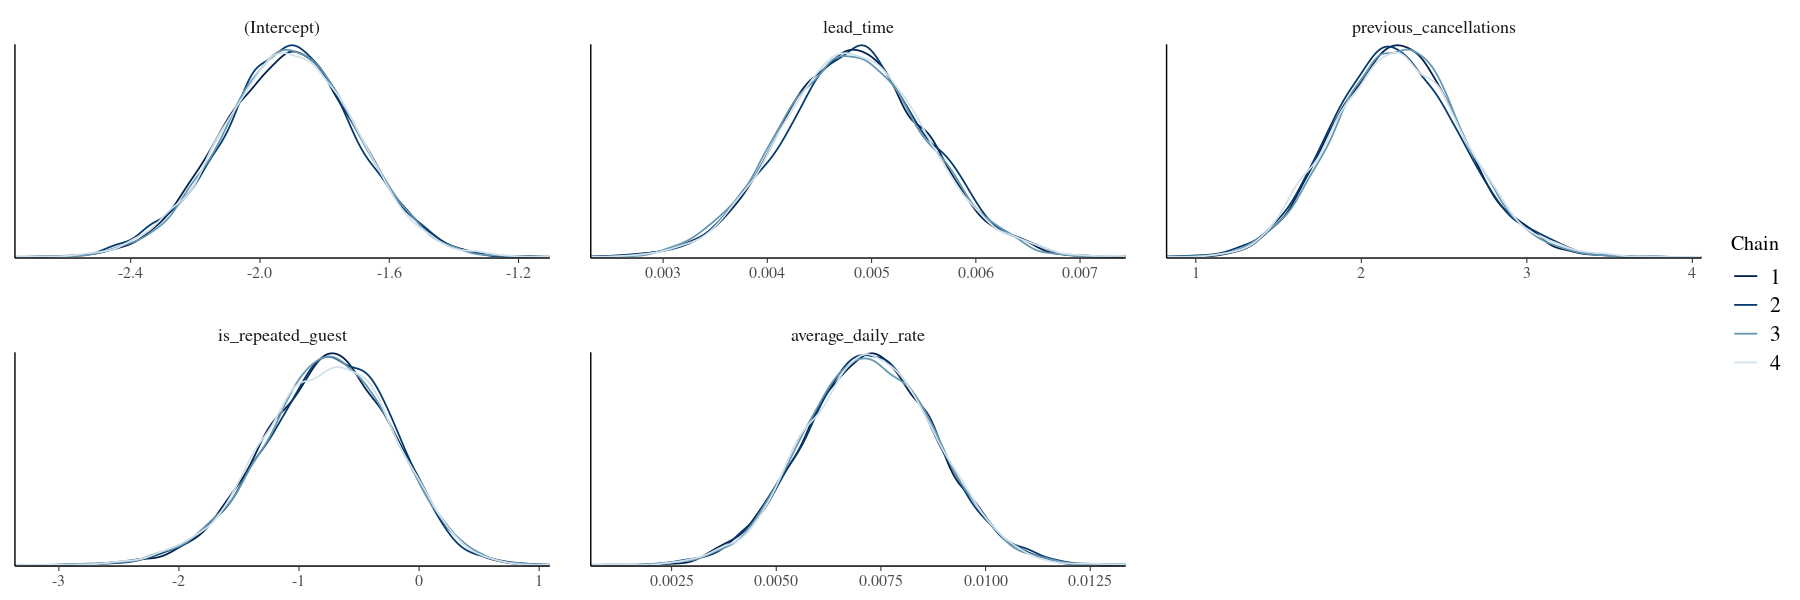

In [22]:
mcmc_dens_overlay( booking_model_1 )

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>.”


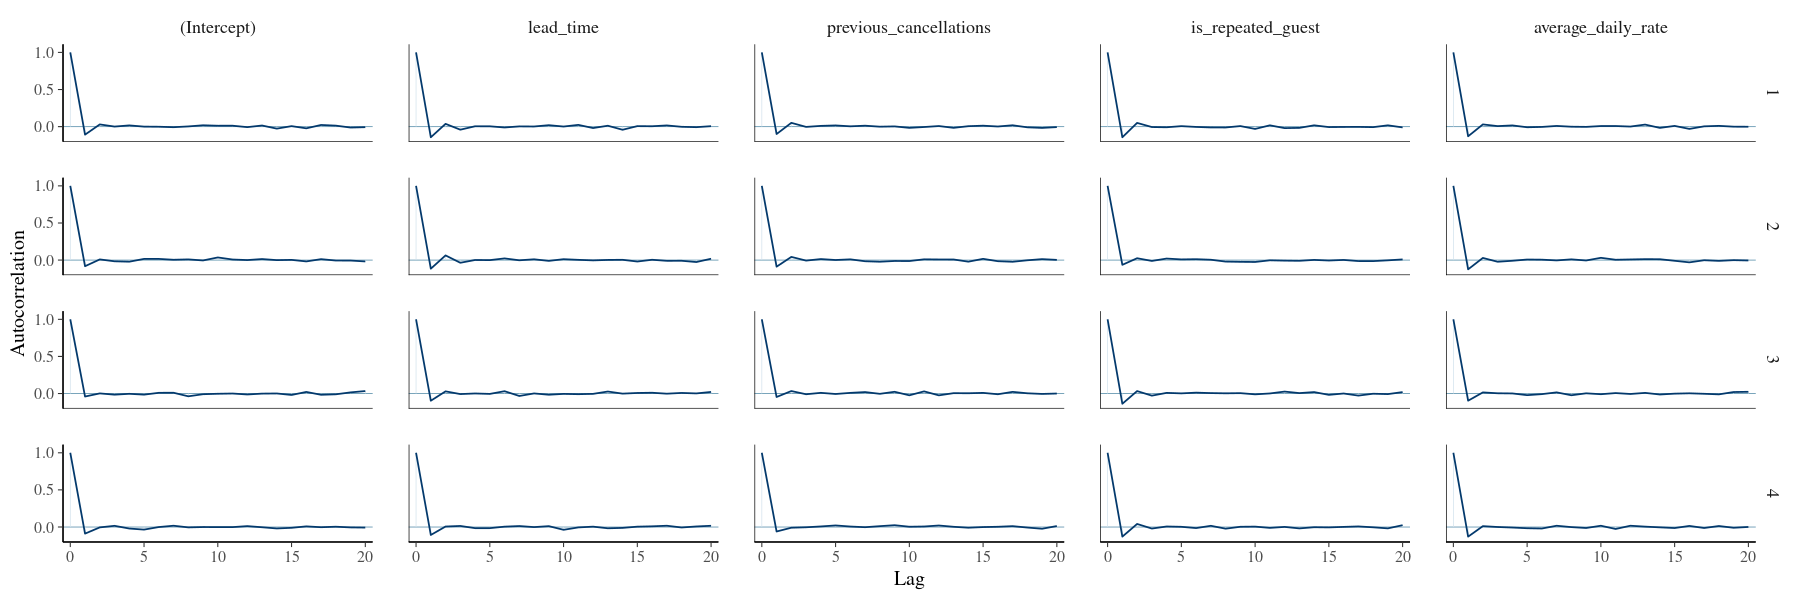

In [23]:
mcmc_acf( booking_model_1 )

Looks good!

Posterior predictive check:

Warning message:
“'nreps' is ignored for this PPC”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


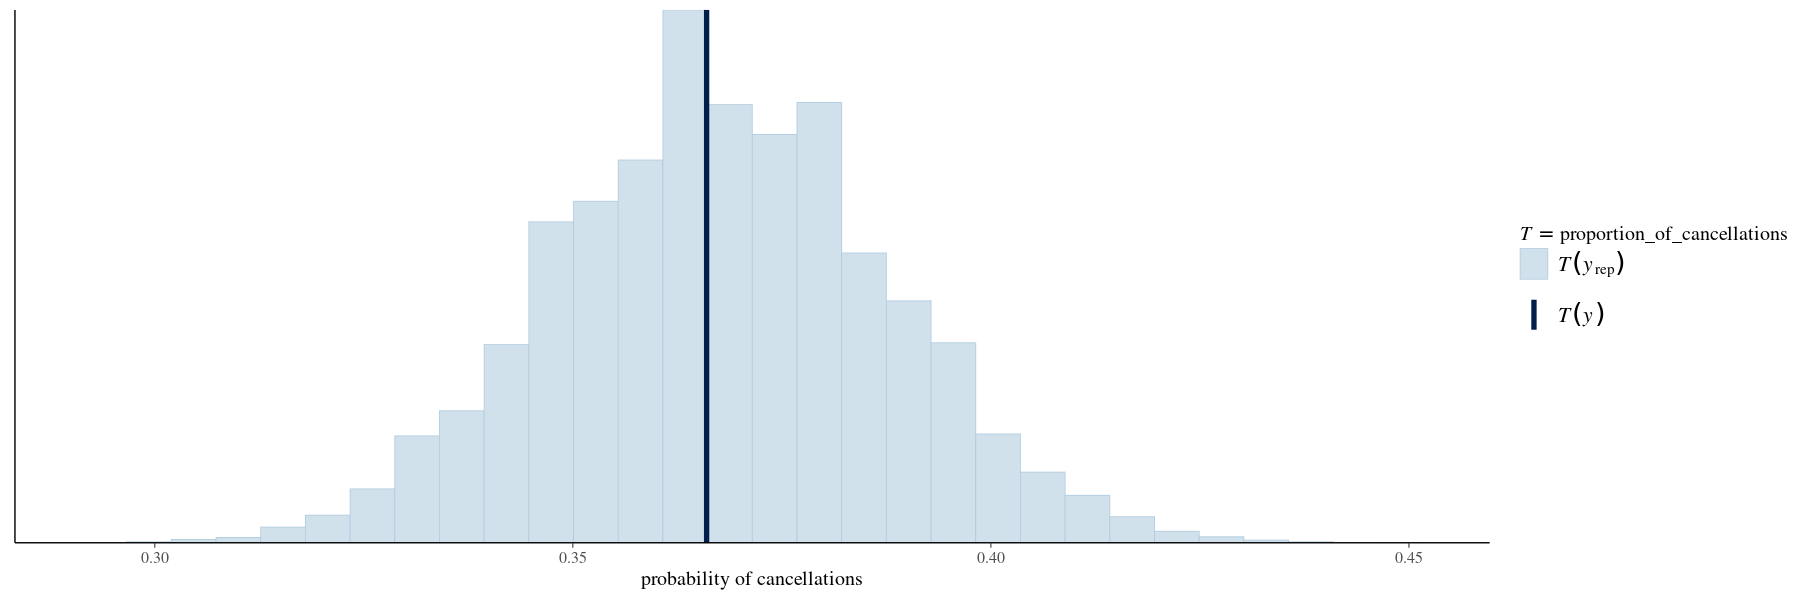

In [24]:
proportion_of_cancellations <- function(x){mean(x == 1)}
pp_check(booking_model_1, nreps = 100,
         plotfun = "stat", stat = "proportion_of_cancellations") + xlab("probability of cancellations")

Appears to be in an ok range.

### b)

In [25]:
tidy(booking_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term                   estimate     std.error   conf.low     conf.high   
1 (Intercept)            -1.909140726 0.206106095 -2.178027271 -1.645967782
2 lead_time               0.004824958 0.000689820  0.003950848  0.005728844
3 previous_cancellations  2.216640092 0.387012270  1.733796500  2.716642477
4 is_repeated_guest      -0.745651735 0.544346703 -1.469581416 -0.080961138
5 average_daily_rate      0.007238742 0.001571894  0.005247197  0.009247278

$$\log\left(\frac{\pi}{1-\pi}\right) = -1.9 + 0.0048 X_1 + 2.2 X_2 -0.75 X_3 + 0.007 X_4$$
$$\frac{\pi}{1-\pi} = \exp\left(-1.9 + 0.0048 X_1 + 2.2 X_2 -0.75 X_3 + 0.007 X_4\right)$$
$$\pi = \frac{1}{1+e^{-z}}, \quad z = -1.9 + 0.0048 X_1 + 2.2 X_2 -0.75 X_3 + 0.007 X_4$$

### c)

$\beta_2$:

In [26]:
c( exp(1.73), exp(2.22), exp(2.72) )

[1]  5.640654  9.207331 15.180322

With every previous cancellation, the odds of a cancellation increase by a factor between 5.6 and 15.2! (As stated before, I think this is very dangerous, I would prefer a field 'has_canceled_previously')

$\beta_3$:

In [27]:
c( exp(-1.47), exp(-0.75), exp(-0.08))

[1] 0.2299255 0.4723666 0.9231163

If the guest has stayed at the hotel before, the odds of cancellation appear to be between cut to one fourth or almost staying the same, what is quite a big uncertainty (also here I see a risk for overfitting to the small number).

### d)

95% confidence interval:

In [28]:
tidy(booking_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term                   estimate     std.error   conf.low     conf.high   
1 (Intercept)            -1.909140726 0.206106095 -2.325342491 -1.508698267
2 lead_time               0.004824958 0.000689820  0.003494805  0.006213864
3 previous_cancellations  2.216640092 0.387012270  1.493876016  3.010409575
4 is_repeated_guest      -0.745651735 0.544346703 -1.890735848  0.226827159
5 average_daily_rate      0.007238742 0.001571894  0.004203853  0.010290770

At the 95%-level it appears that lead_time, previous_cancellations and average daily rate are significantly related to the cancellation rate. The 95%-CI for is_repeated_guest encloses zero and is therefore not significant at this level. From the considerations in exercise 13.7 I have however my doubts how well 'previous_cancellations' and 'average_daily_rate' work in reality.

## Exercise 13.8

### a)

In-sample:

In [29]:
classification_summary(model = booking_model_1, data = hotel_bookings, cutoff = 0.5)

$confusion_matrix
 y   0   1
 0 574  60
 1 250 116

$accuracy_rates
                          
sensitivity      0.3169399
specificity      0.9053628
overall_accuracy 0.6900000

CV:

In [30]:
cv_accuracy <- classification_summary_cv(model = booking_model_1, data = hotel_bookings, cutoff = 0.5, k = 10)
cv_accuracy$cv

sensitivity specificity overall_accuracy
1 0.3019413   0.9048041   0.684

In [31]:
cv_accuracy$folds$overall_accuracy

[1] 0.70 0.61 0.67 0.66 0.64 0.68 0.66 0.71 0.71 0.80

### b)

Sensitivity, specificity and overall accuracy are very similar. In general this makes sense, because it is hard for a linear model to overfit to data. However I am surprised that the low numbers in previous_cancellations and is_repeated_guest did not have a bigger impact.

### c)

The model will correctly predict whether a room is canceled or not in 69% of the cases. Out of all the rooms that will be canceled, the model can only find 32% and out of all rooms that will not be canceled, it can find 91%.

### d)

In [32]:
find_sens_spec <- function( cutoff ) {
    sm <- classification_summary(model = booking_model_1, data = hotel_bookings, cutoff = cutoff)
    c( cutoff, sm$accuracy_rates[[1]] )
}

df <- data.frame( matrix(nrow=0, ncol=4) )
colnames(df) <- c("cutoff", "sensitivity", "specificity", "overall_accuracy")
for (c in seq(0.1,0.95,0.05)) {
    df[nrow(df)+1,] = find_sens_spec( c )
}

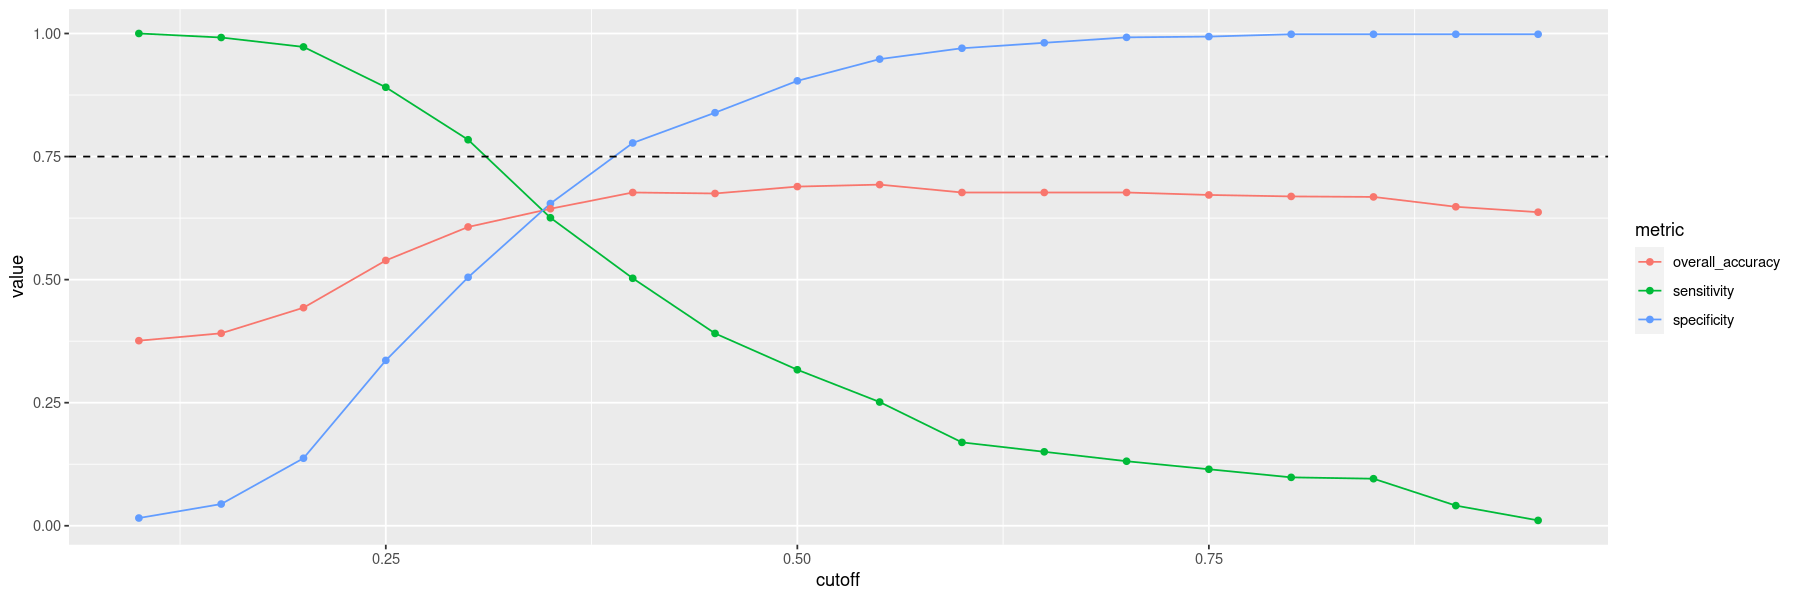

In [33]:
df %>% 
    pivot_longer( sensitivity:overall_accuracy, names_to="metric" ) %>% 
    ggplot( aes(x=cutoff, y=value, color=metric) ) +
    geom_line() +
    geom_point() +
    geom_hline( yintercept=0.75, linetype="dashed", color = "black" )

In [34]:
df %>% filter( abs(sensitivity-0.75) < 0.2 )

cutoff sensitivity specificity overall_accuracy
1 0.25   0.8907104   0.3359621   0.539           
2 0.30   0.7841530   0.5047319   0.607           
3 0.35   0.6256831   0.6545741   0.644

For a sensitivity close to 75%, i.e. capturing about 75% of all cancellations, a cutoff threshold of 0.3 needs to be set. This results in a specificity of 51%, i.e. half of all non-cancellations are predicted as cancellations (false positives).

## Exercise 3.9

### a)

Simulate:

In [35]:
booking_model_1_df <- data.frame(booking_model_1)
preds <- booking_model_1_df %>% 
    mutate( mu=X.Intercept. + lead_time*30 + is_repeated_guest*0 + previous_cancellations*1 + average_daily_rate*100 ) %>% 
    mutate( odds=exp(mu), prob=odds/(odds+1) ) %>% 
    mutate( Y=rbinom(nrow(booking_model_1_df), size=1, prob=prob) )
head( preds )

X.Intercept. lead_time   previous_cancellations is_repeated_guest
1 -2.067350    0.004819027 2.652966               -0.6439337       
2 -2.004914    0.003755334 2.524631               -0.5101437       
3 -2.078681    0.004511512 2.720257               -1.1924180       
4 -2.211178    0.004633320 2.262709               -0.6388802       
5 -1.619227    0.004681103 1.912430               -0.7522682       
6 -1.690405    0.005637259 2.433125               -0.7060644       
  average_daily_rate mu        odds     prob      Y
1 0.008666092        1.5967956 4.937186 0.8315700 0
2 0.008897862        1.5221634 4.582128 0.8208568 1
3 0.009052037        1.6821243 5.376966 0.8431856 1
4 0.009974415        1.1879714 3.280420 0.7663781 1
5 0.005492169        0.9828526 2.672068 0.7276739 1
6 0.004518225        1.3636604 3.910481 0.7963540 1

Distribution of probabilities:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


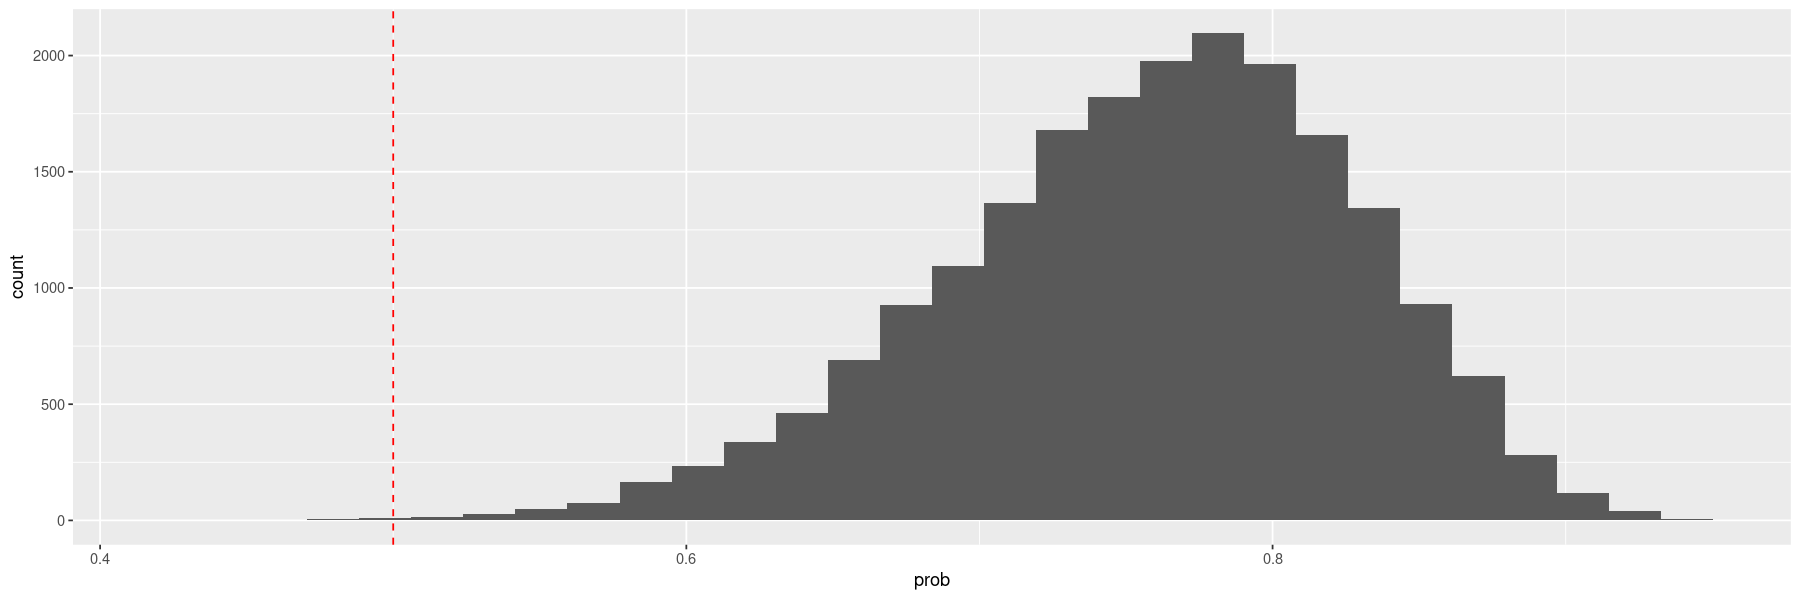

In [36]:
ggplot( preds ) + geom_histogram( aes(x=prob) ) + geom_vline( xintercept=0.5, color="red", linetype="dashed" )

Distribution of model predictions:

Warning message:
“The dot-dot notation (`..prop..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(prop)` instead.”


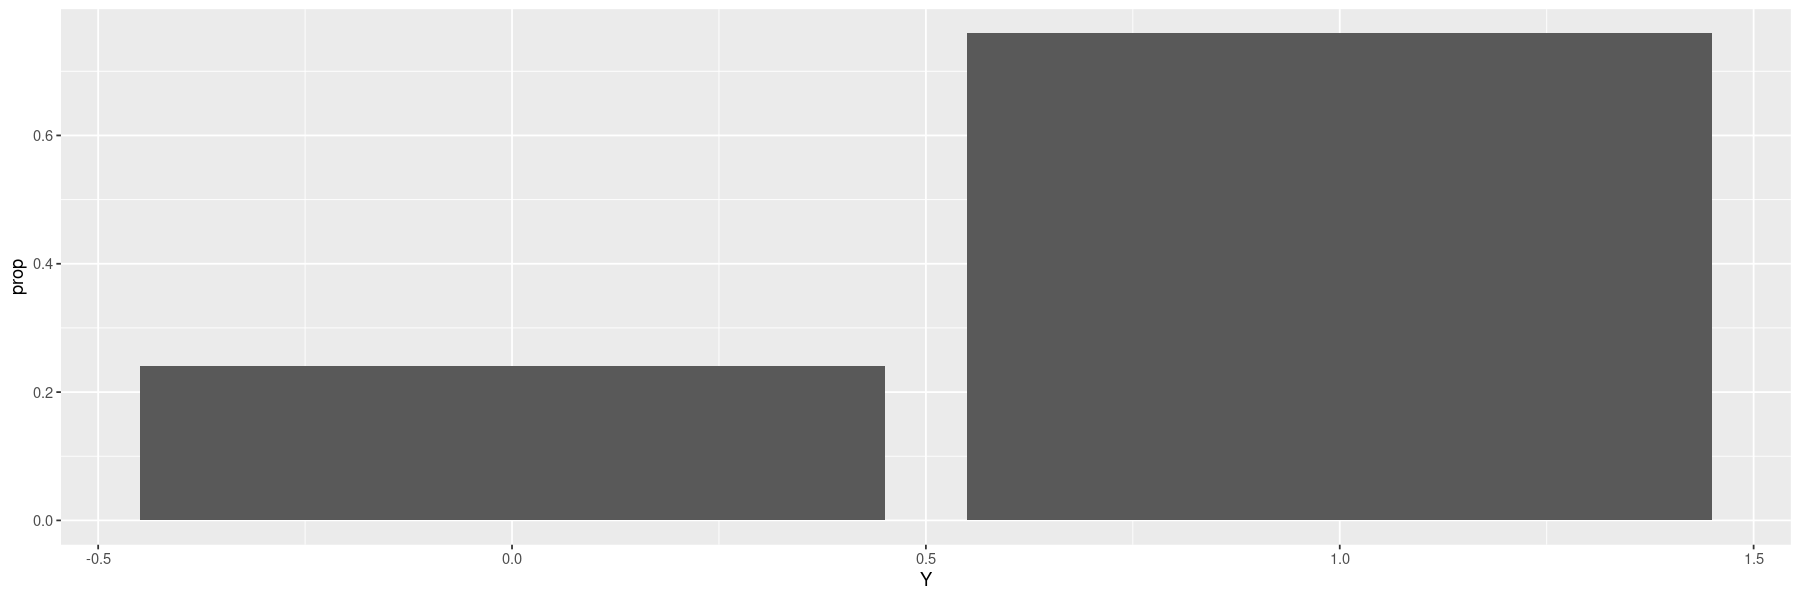

In [37]:
ggplot( preds, aes(x = Y) ) + geom_bar( aes(y=..prop.., group=1))

In [38]:
mean( preds$Y )

[1] 0.7589

The model predicts a cancellation in 76% of all the time. In a bet I would place my money in favour of the guest cancelling.

### b)

This can for example be achieved by setting the number of previous cancellations higher. Then it does not really matter what the rest of the variables is:

In [39]:
preds2 <- booking_model_1_df %>% 
    mutate( mu=X.Intercept. + lead_time*30 + is_repeated_guest*0 + previous_cancellations*5 + average_daily_rate*250 ) %>% 
    mutate( odds=exp(mu), prob=odds/(odds+1) ) %>% 
    mutate( Y=rbinom(nrow(booking_model_1_df), size=1, prob=prob) )
mean(preds2$Y)

[1] 1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


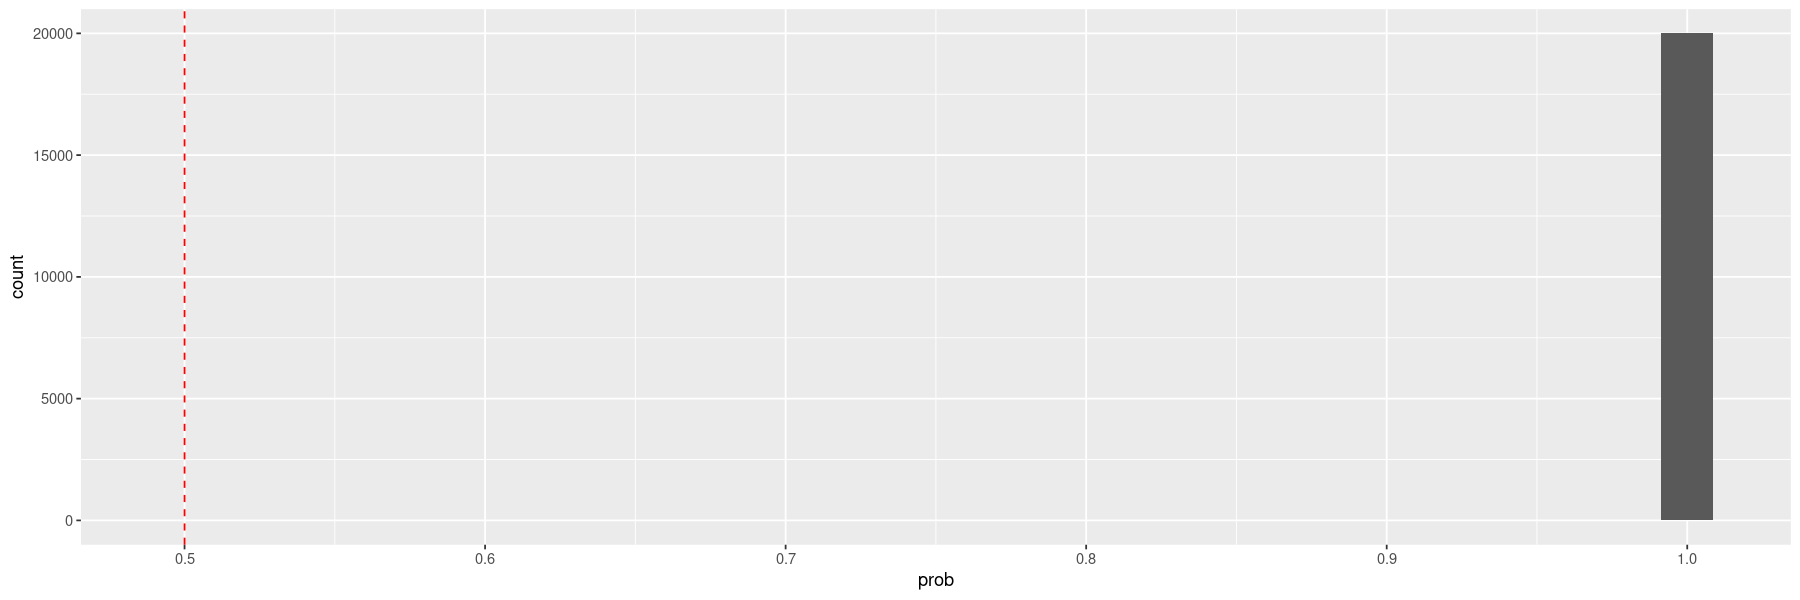

In [40]:
ggplot( preds2 ) + geom_histogram( aes(x=prob) ) + geom_vline( xintercept=0.5, color="red", linetype="dashed" )

I would advocate here for not treating previous_cancellations as a numeric variable.

## Exercise 13.10

In [42]:
robot_data <- pulse_of_the_nation %>% select( robots, transformers, books, age, income )
head( robot_data )

robots   transformers books age income
1 Unlikely 1            20    64    8   
2 Unlikely 0             6    56   68   
3 Unlikely 0             0    63   46   
4 Unlikely 0             1    48   51   
5 Unlikely 1            30    32  100   
6 Unlikely 0            15    64   54

### a)

In [43]:
robot_data %>% group_by( robots ) %>% summarise( unlikely_prop=n()/nrow(robot_data) )

robots   unlikely_prop
1 Likely   0.199        
2 Unlikely 0.801

Around 80% believe that it is unlikely.

### b)

#### Transformers

In [44]:
robot_data %>% 
    group_by( transformers ) %>% 
    summarise( count=n() )

transformers count
1 0            459  
2 1            157  
3 2            155  
4 3            111  
5 4             67  
6 5             51

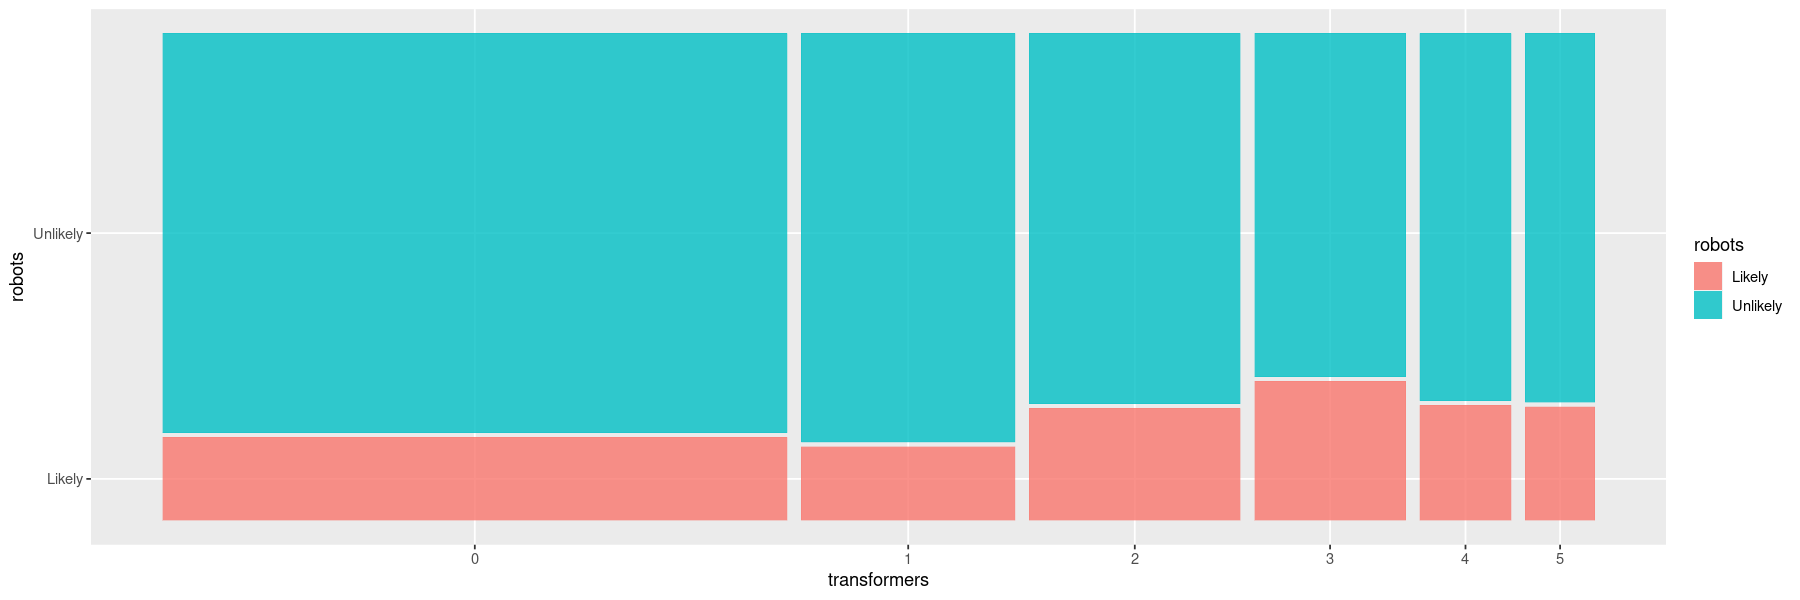

In [45]:
ggplot( data=robot_data ) + geom_mosaic( aes(x=product(robots, transformers), fill=robots) )

It appears that watching 2 or more transformer movies very slightly increases the belief that robots will take over. This might not be significant.

#### Books

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


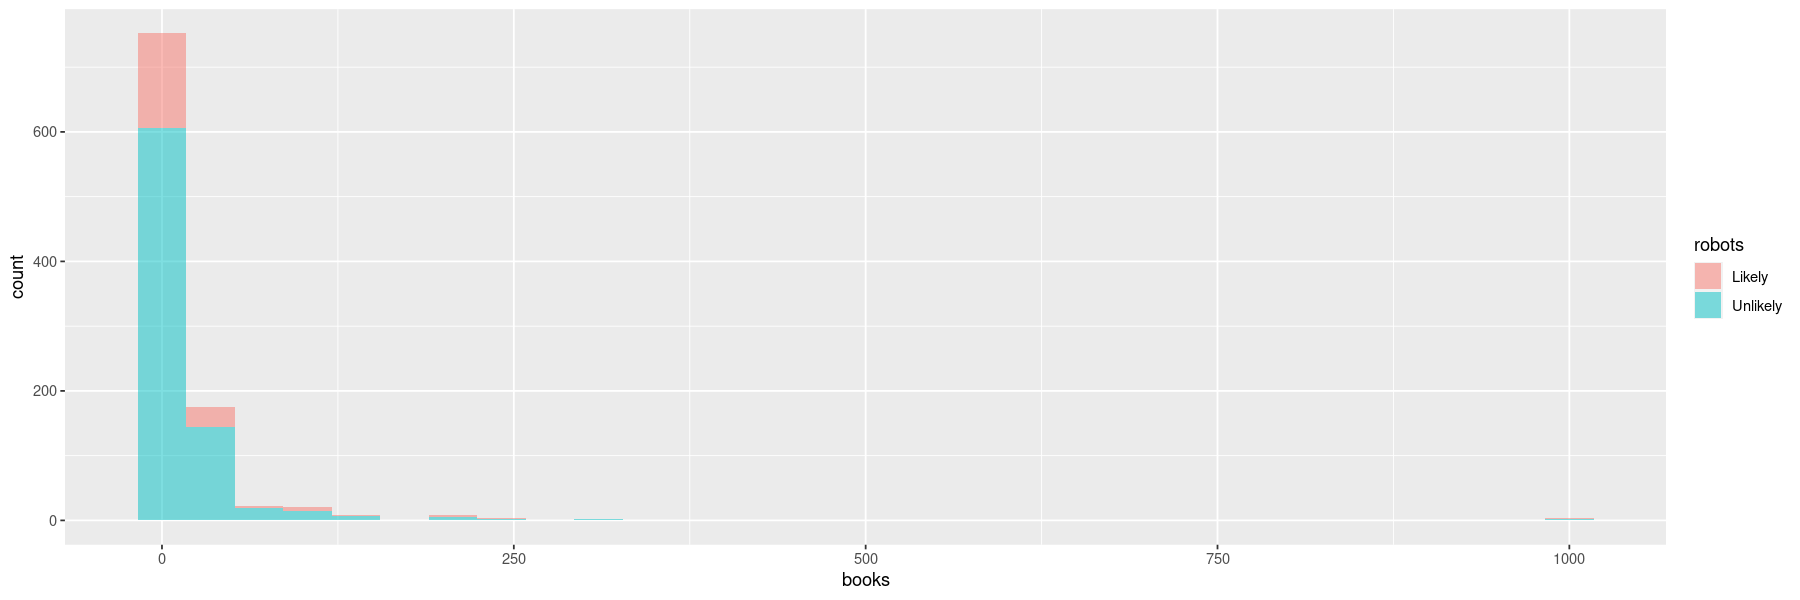

In [46]:
ggplot( robot_data ) + geom_histogram( aes(x=books, fill=robots), alpha=0.5 )

It looks like people who read few books believe it is more likely that robots will take over the world, however this is might not be significant.

#### Age

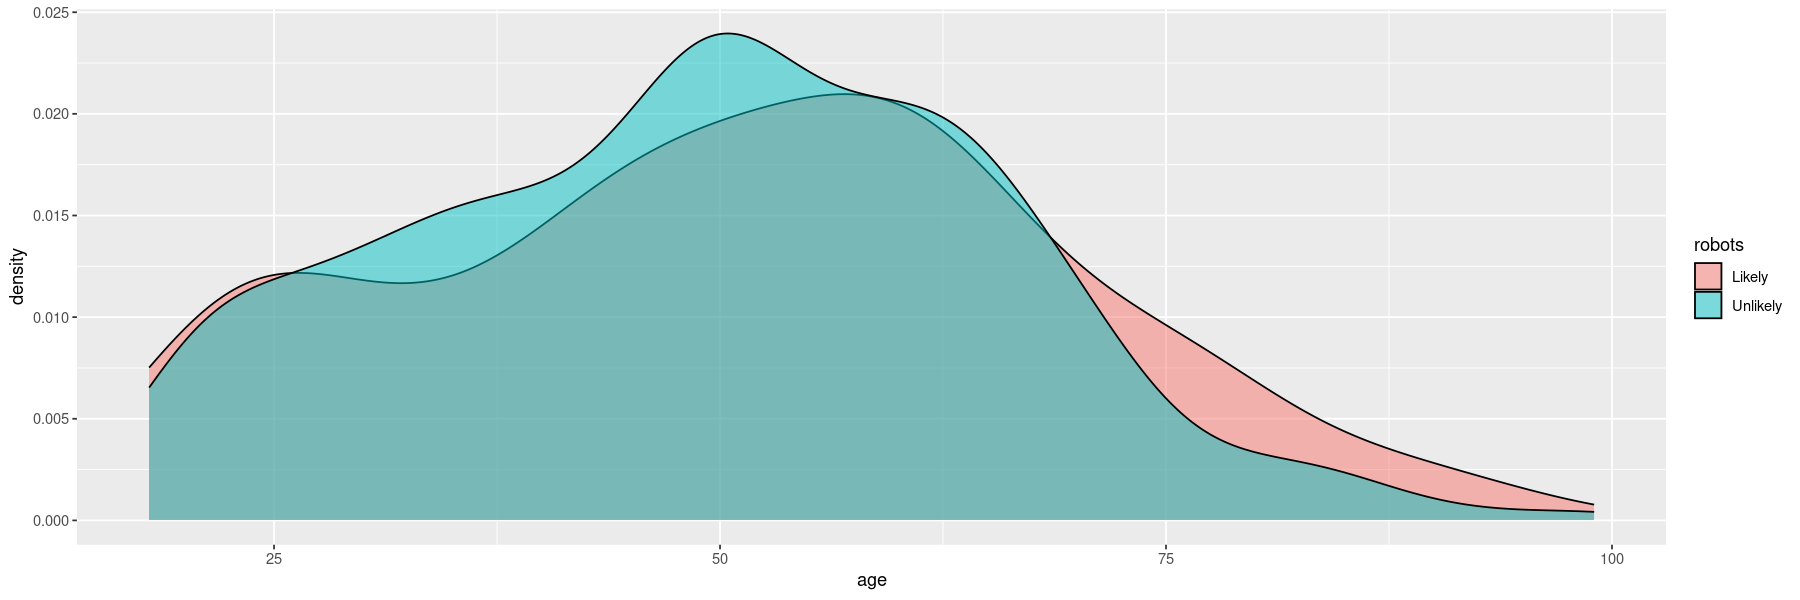

In [47]:
ggplot( robot_data ) + geom_density( aes(x=age, fill=robots), alpha=0.5 )

It looks like people above 70 believe it is more likely that robots will take over the world.

#### Income

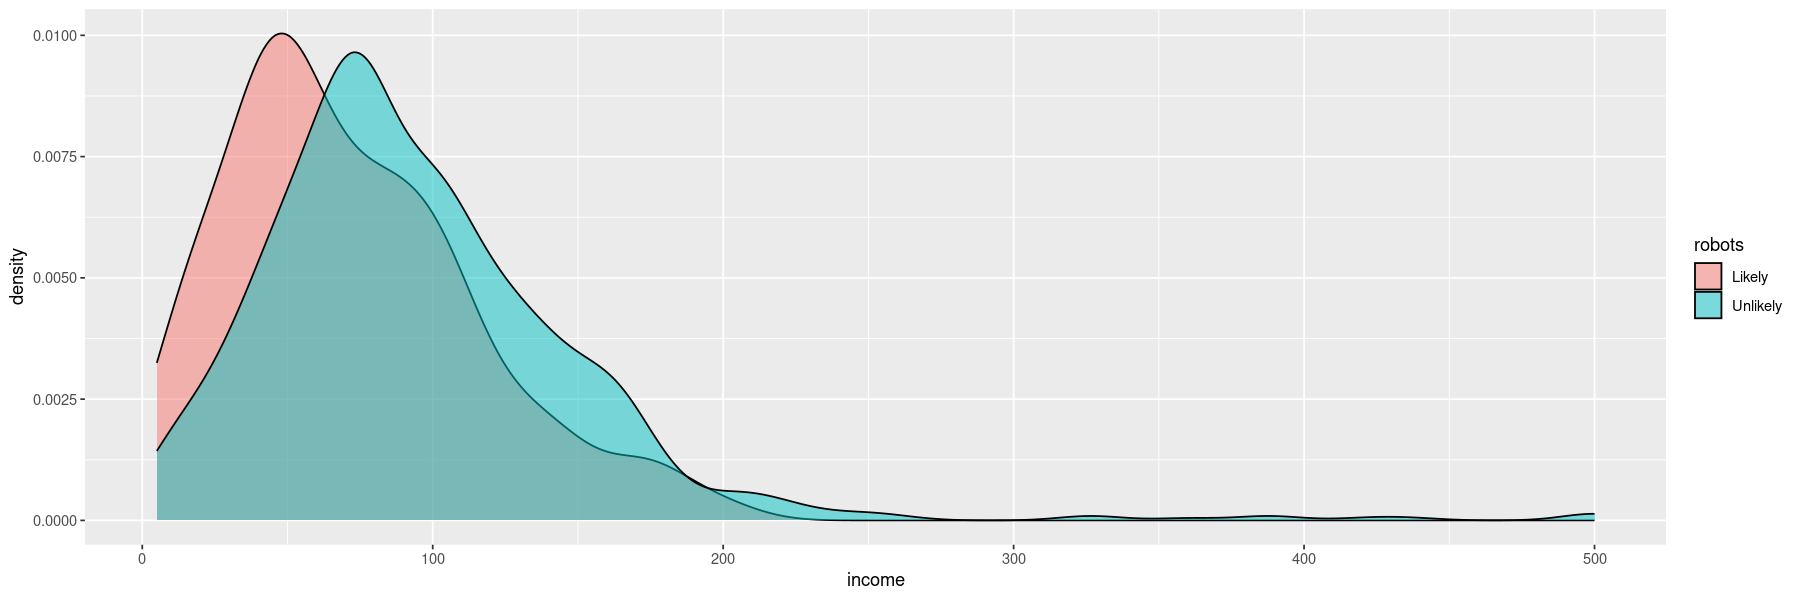

In [48]:
ggplot( robot_data ) + geom_density( aes(x=income, fill=robots), alpha=0.5 )

It appears that people with low income believe it is more likely that robots will take over the world.

### c)

Prior on intercept: Reasonable range for $\pi$ between 0.5 and 0.95, centered at 0.8. In terms of log-odds:

In [49]:
log(0.8/(1-0.8))

[1] 1.386294

A probability of 0.5 corresponds to a log-odds of $0$ and 0.95 to a log-odds of $\approx 3$.

In [50]:
log(0.5/(1-0.5))

[1] 0

In [51]:
log(0.95/(1-0.95))

[1] 2.944439

This can be more or less reproduced with a Gaussian prior centered around 1.4 with a standard deviation of 0.8:

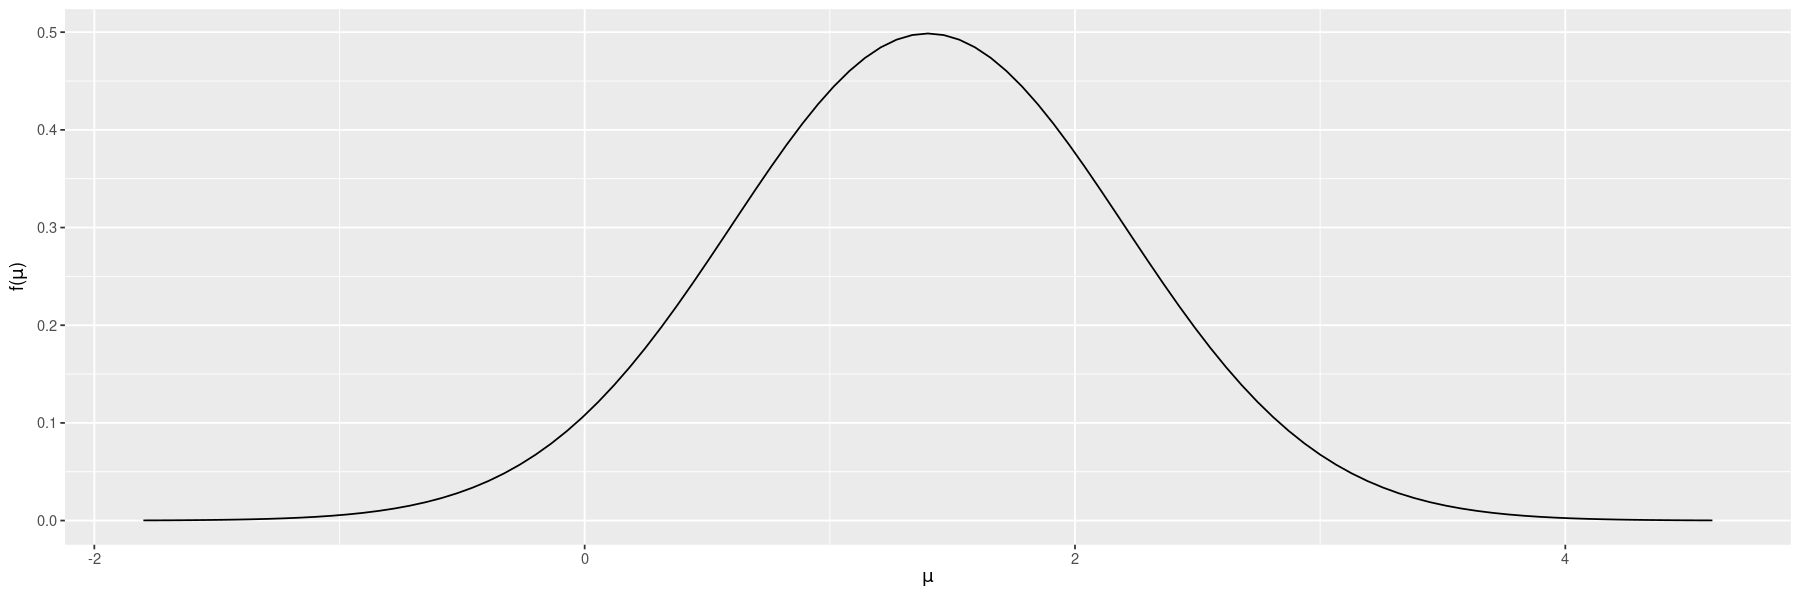

In [52]:
plot_normal( mean=1.4, sd=0.8 )

Resulting model:

$$Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\beta_4 \sim \text{Bern}(\pi_i), \quad \log\left(\frac{\pi_i}{1-\pi_i}\right) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \beta_3 X_{3i} + \beta_4 X_{4i} $$

$$\beta_0 \sim N(0.4,0.8)$$
$$\beta_1 \sim N(0,\cdot)$$
$$\beta_2 \sim N(0,\cdot)$$
$$\beta_3 \sim N(0,\cdot)$$
$$\beta_4 \sim N(0,\cdot)$$

where $\cdot$ stands for `autoscale=TRUE` (weakly informed prior).

### d)

Since the outcome (likely/unlikely) is of binary categorical nature, it is best modeled with a Bernoulli distribution. The parameter $\pi$ of the distribution needs to be modeled as a probablity in the interval [0,1], what is done best with a sigmoid function or equally by modeling the log-odds with a linear ansatz. Since $\beta_1$, ..,  $\beta_4$ are again parameters of a linear model, we can assume Gaussian priors as usual.

## Exercise 13.11

### a)

Simulate the model:

In [53]:
robot_model_1 <- stan_glm( robots ~ transformers + books + age + income,
                             data = robot_data, family = binomial,
                             prior_intercept = normal(1.4, 0.8),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.464295 seconds (Warm-up)
Chain 1:                0.559222 seconds (Sampling)
Chain 1:  

Prior summary:

In [54]:
prior_summary( robot_model_1 )

Priors for model 'robot_model_1' 
------
Intercept (after predictors centered)
 ~ normal(location = 1.4, scale = 0.8)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [1,1,1,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [0.649,0.013,0.060,...])
------
See help('prior_summary.stanreg') for more details

Diagnostics:

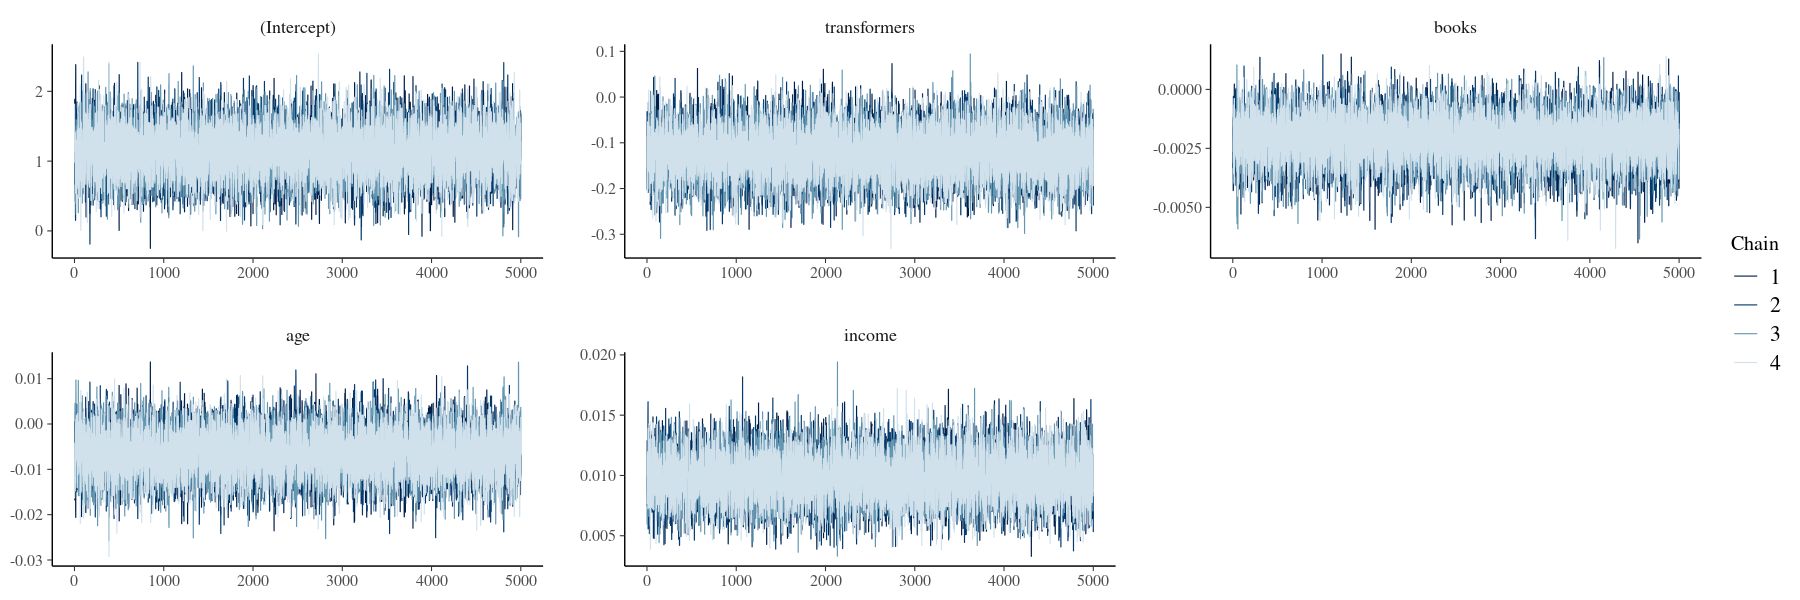

In [55]:
mcmc_trace( robot_model_1 )

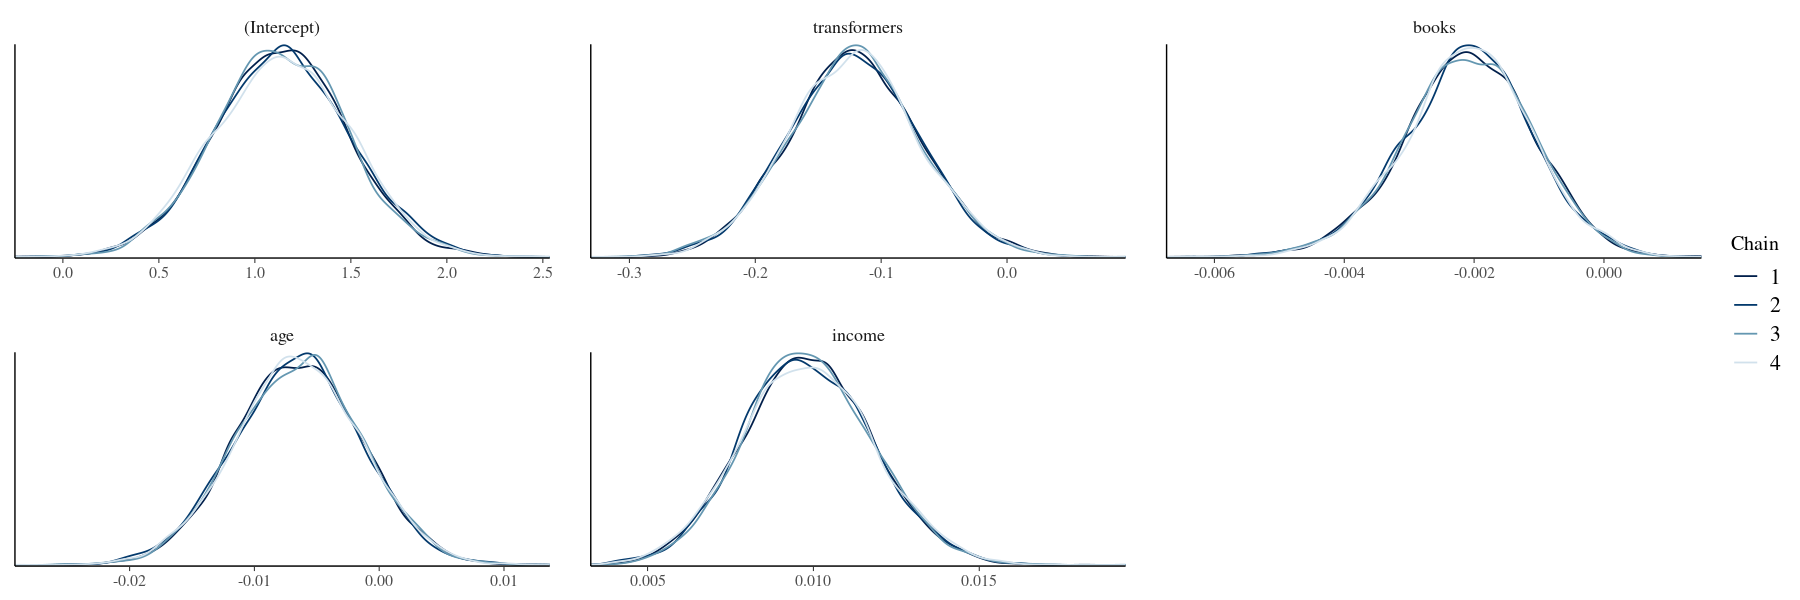

In [56]:
mcmc_dens_overlay( robot_model_1 )

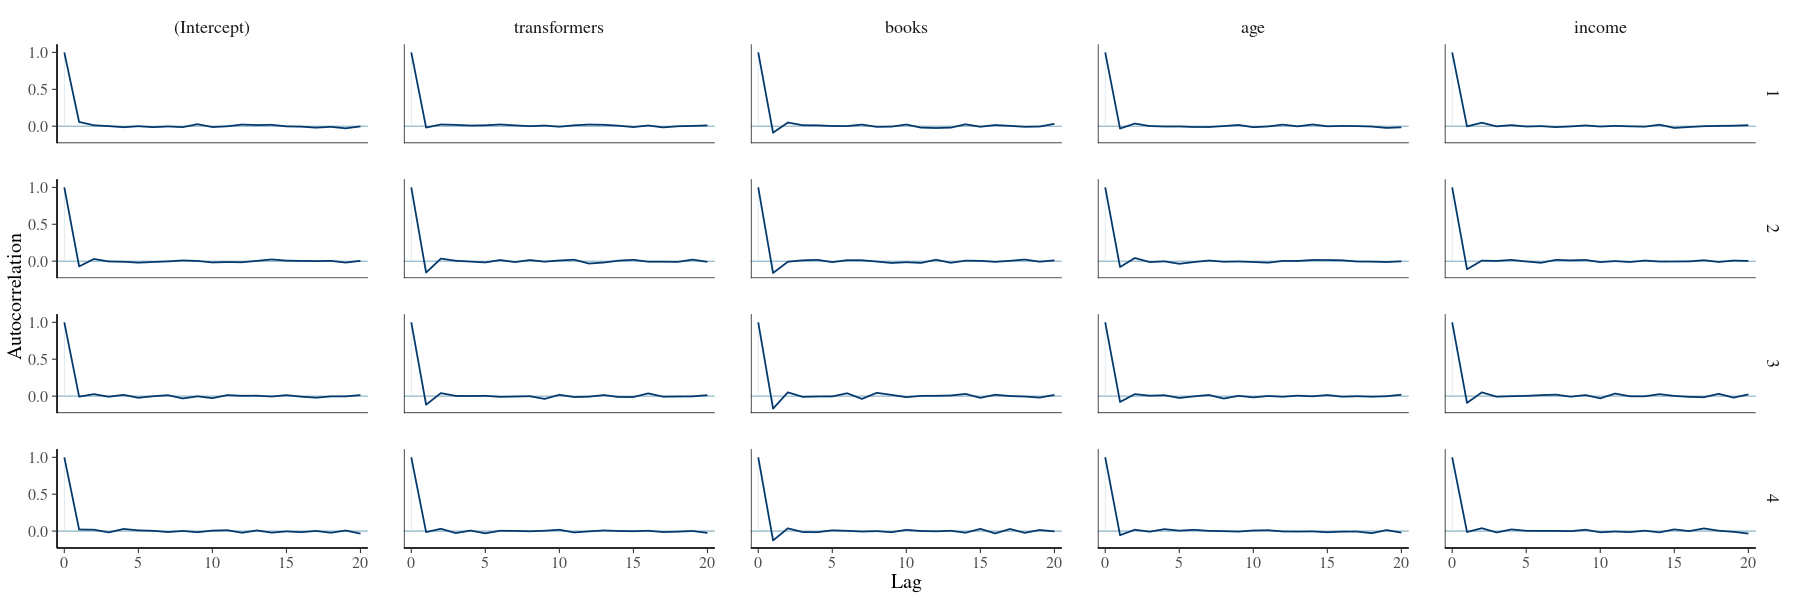

In [57]:
mcmc_acf( robot_model_1 )

Looks good!

Posterior predictive check:

Warning message:
“'nreps' is ignored for this PPC”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


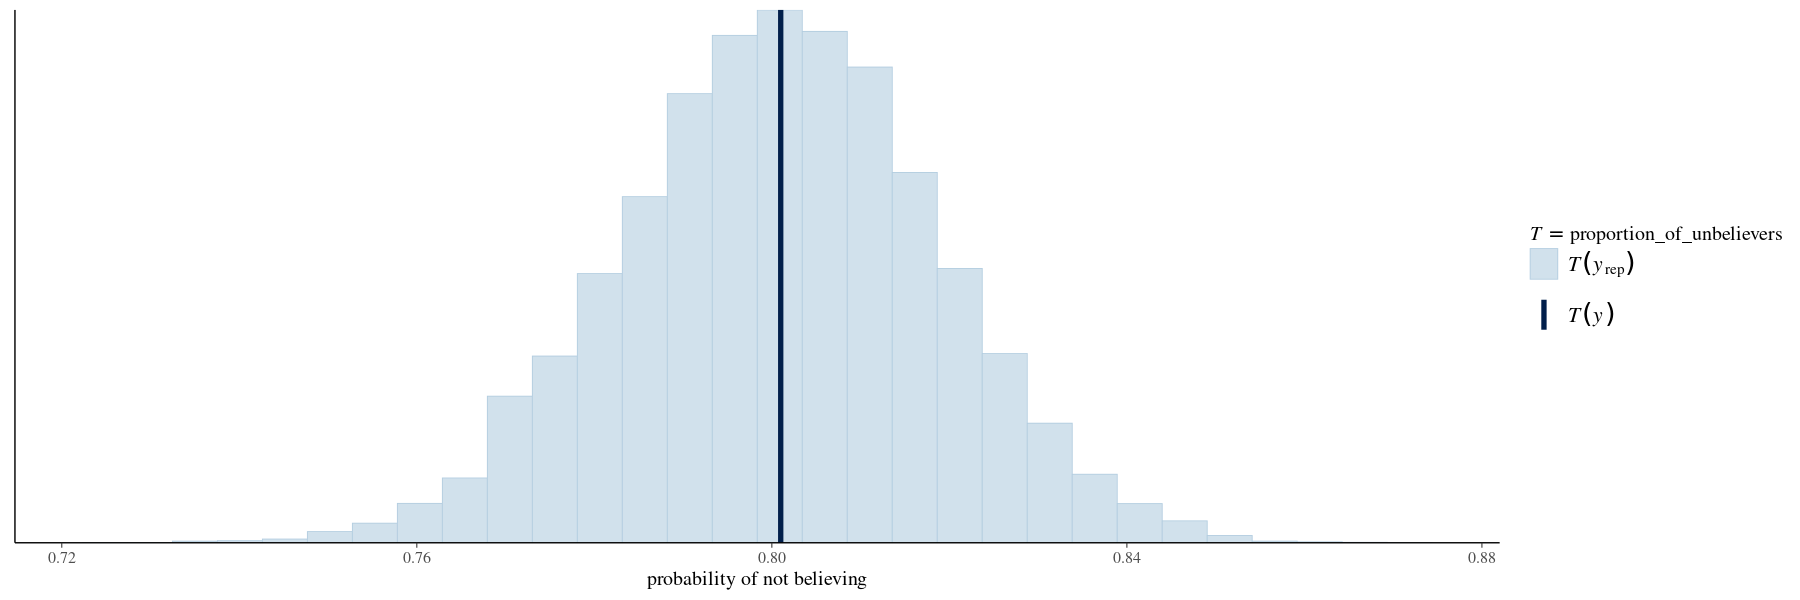

In [58]:
proportion_of_unbelievers <- function(x){mean(x == 1)}
pp_check(robot_model_1, nreps = 100,
         plotfun = "stat", stat = "proportion_of_unbelievers") + xlab("probability of not believing")

Appears to be in an ok range.

### b)

In [59]:
tidy(robot_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term         estimate     std.error    conf.low     conf.high    
1 (Intercept)   1.139334821 0.3480184360  0.692670549  1.582254e+00
2 transformers -0.121588725 0.0510392103 -0.188425271 -5.465837e-02
3 books        -0.002080105 0.0009633804 -0.003376087 -8.505848e-04
4 age          -0.006461826 0.0050434602 -0.012965282 -5.122908e-06
5 income        0.009800610 0.0019556609  0.007365586  1.237479e-02

$$\log\left(\frac{\pi}{1-\pi}\right) = 1.14 - 0.12 X_1 - 0.002 X_2 - 0.006 X_3 + 0.010 X_4$$
$$\frac{\pi}{1-\pi} = \exp\left(1.14 - 0.12 X_1 - 0.002 X_2 - 0.006 X_3 + 0.010 X_4\right)$$
$$\pi = \frac{1}{1+e^{-z}}, \quad z = 1.14 - 0.12 X_1 - 0.002 X_2 - 0.006 X_3 + 0.010 X_4$$

### c)

$\beta_3$:

In [60]:
c( exp(-0.013), exp(-0.006), exp(-5.1e-6) )

[1] 0.9870841 0.9940180 0.9999949

Age has a very small impact. With every year more, around 0-1% more people believe that robots take over the world.

$\beta_4$:

In [61]:
c( exp(0.0074), exp(0.0098), exp(0.012) )

[1] 1.007427 1.009848 1.012072

With every dollar of income, between 0-1% less people believe that robots take over the world.

### d)

95% confidence interval:

In [62]:
tidy(robot_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term         estimate     std.error    conf.low     conf.high    
1 (Intercept)   1.139334821 0.3480184360  0.453066782  1.8229782306
2 transformers -0.121588725 0.0510392103 -0.223538160 -0.0190189544
3 books        -0.002080105 0.0009633804 -0.004142485 -0.0001981823
4 age          -0.006461826 0.0050434602 -0.016463324  0.0033468971
5 income        0.009800610 0.0019556609  0.006090984  0.0137529405

At the 95%-level it appears that transformers, book and income are significantly related to the belief that robots take over the world within the next 10 years. Age does not appear to be significantly related to this belief.

At the 99% confidence level, also transformers and books drop out, what is somehow expected:

In [63]:
tidy(robot_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.99)

term         estimate     std.error    conf.low     conf.high   
1 (Intercept)   1.139334821 0.3480184360  0.240898975 2.0484447280
2 transformers -0.121588725 0.0510392103 -0.254841633 0.0140178974
3 books        -0.002080105 0.0009633804 -0.004902721 0.0003656827
4 age          -0.006461826 0.0050434602 -0.019859359 0.0064090354
5 income        0.009800610 0.0019556609  0.005002534 0.0149679852

I could somehow imagine that number of books and income somehow correlate with education level and that age is correlated with understanding of technology. Probably the number of transformer movies is confounded with another quantity, I don't see directly how it impacts belief/non-belief in that robots will take over the world.

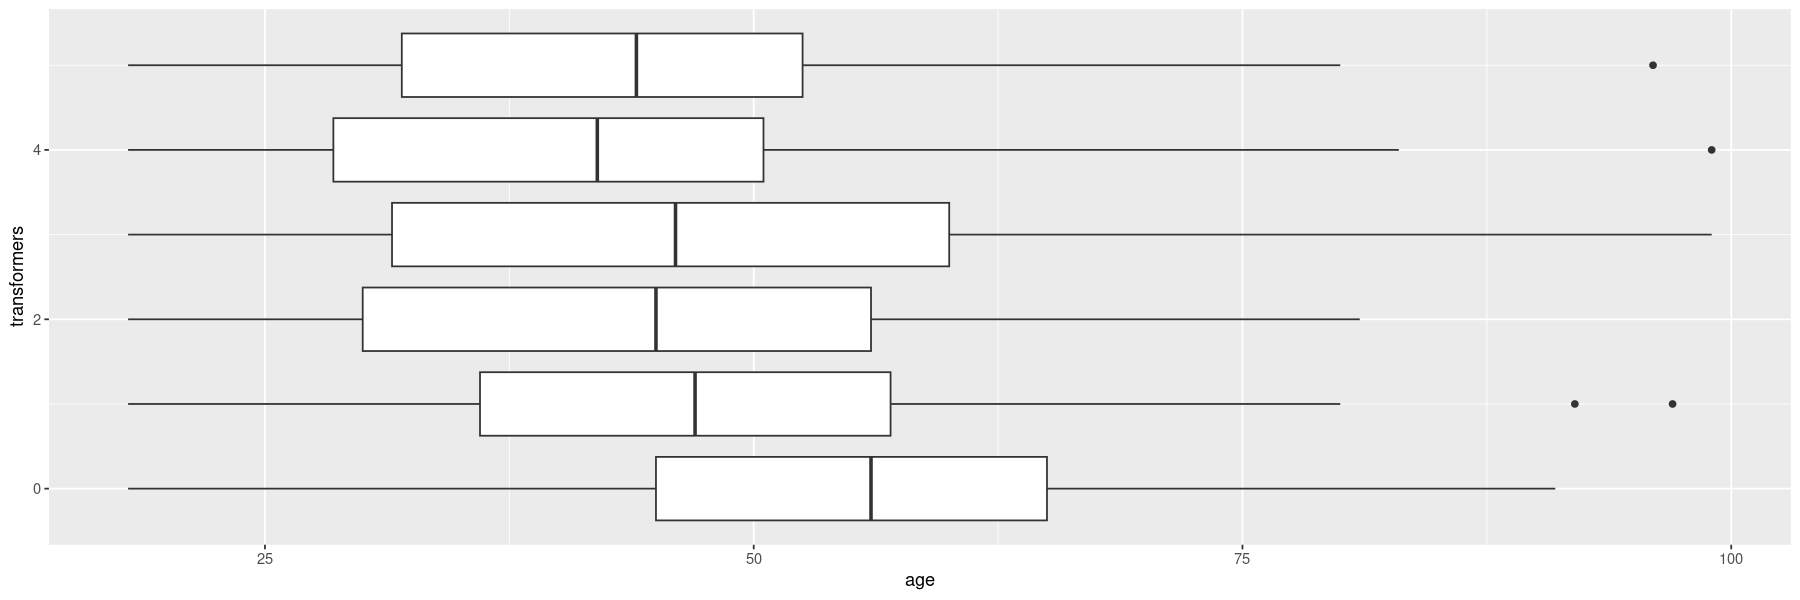

In [64]:
ggplot( robot_data ) + geom_boxplot( aes(x=age, y=transformers, group=transformers))

It appears that the number of watched transformer movies is also correlated with age and then also income.

## Exercise 13.12

### a)

In [65]:
robot_data %>% summarize_all( function(x) {mean(is.na(x))} )

robots transformers books age income
1 0      0            0     0   0

In-sample:

In [66]:
classification_summary(model = robot_model_1, data = robot_data, cutoff = 0.6)

$confusion_matrix
        y 0   1
   Likely 8 191
 Unlikely 7 794

$accuracy_rates
                           
sensitivity      0.99126092
specificity      0.04020101
overall_accuracy 0.80200000

CV (Use 5 folds - there appears to be a problem with the cutoff, leading to missing values):

In [67]:
cv_accuracy <- classification_summary_cv(model = robot_model_1, data = robot_data, cutoff = 0.6, k = 5)
cv_accuracy$cv

sensitivity specificity overall_accuracy
1 0.9913289   0.03682964  0.801

In [68]:
cv_accuracy$folds

fold sensitivity specificity overall_accuracy
1 1    0.9935897   0.02272727  0.780           
2 2    0.9939759   0.05882353  0.835           
3 3    0.9936709   0.00000000  0.785           
4 4    0.9818182   0.05714286  0.820           
5 5    0.9935897   0.04545455  0.785

Interestingly, the sensitivity is extremely large (if somebody does not believe that robots take over the world we capture them with quite some confidence), however the specificity is quite low, practically zero. It appears that our model cannot really predict who believes that robots take over the world with the given cutoff.

### b)

Sensitivity, specificity and overall accuracy are more or less similar. In general this makes sense, because it is hard for a linear model to overfit to data.

### c)

The model practically predicts 'unlikely' for almost all data points. With the given class proportion of 0.8, this results in a default accuracy of 80%. Obviously, the sensitivity is almost 100% and the specificity pracically zero percent.

## Exercise 13.13

In [69]:
fake_news <- fake_news %>% select( type, title_has_excl, title_words, negative )
head( fake_news )

type title_has_excl title_words negative
1 fake FALSE          17          8.47    
2 real FALSE          18          4.74    
3 fake  TRUE          16          3.33    
4 real FALSE          11          6.09    
5 fake FALSE           9          2.66    
6 real FALSE          12          3.02

### Exploratory Data Analysis

#### Exclamation mark

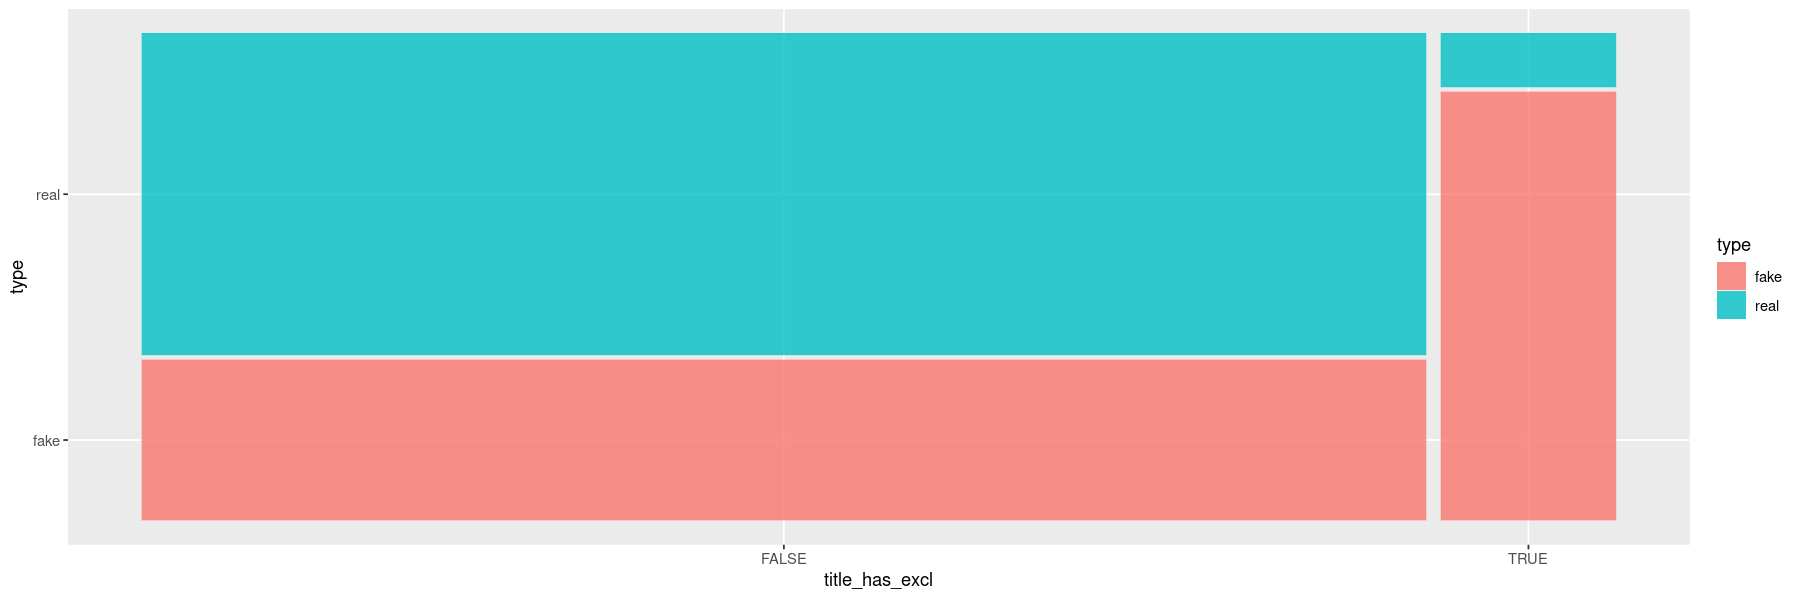

In [70]:
ggplot( data=fake_news ) + geom_mosaic( aes(x=product(type, title_has_excl), fill=type) )

There appears to be a significant relationship between exclamation marks and fake news.

#### Number of words

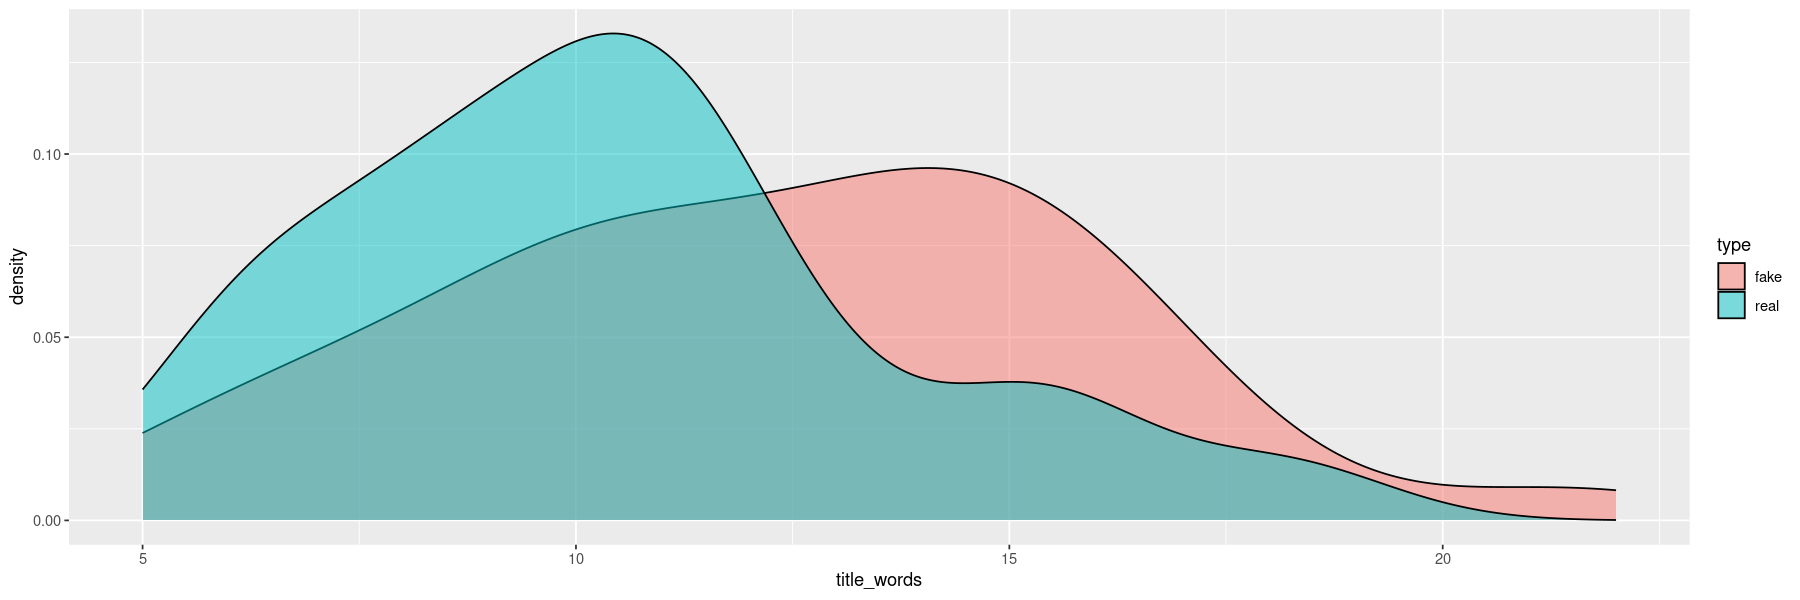

In [71]:
ggplot( data=fake_news ) + geom_density( aes(x=title_words, fill=type), alpha=0.5 )

Fake news appear to have more words in the title.

#### Percent words with a negative sentiment

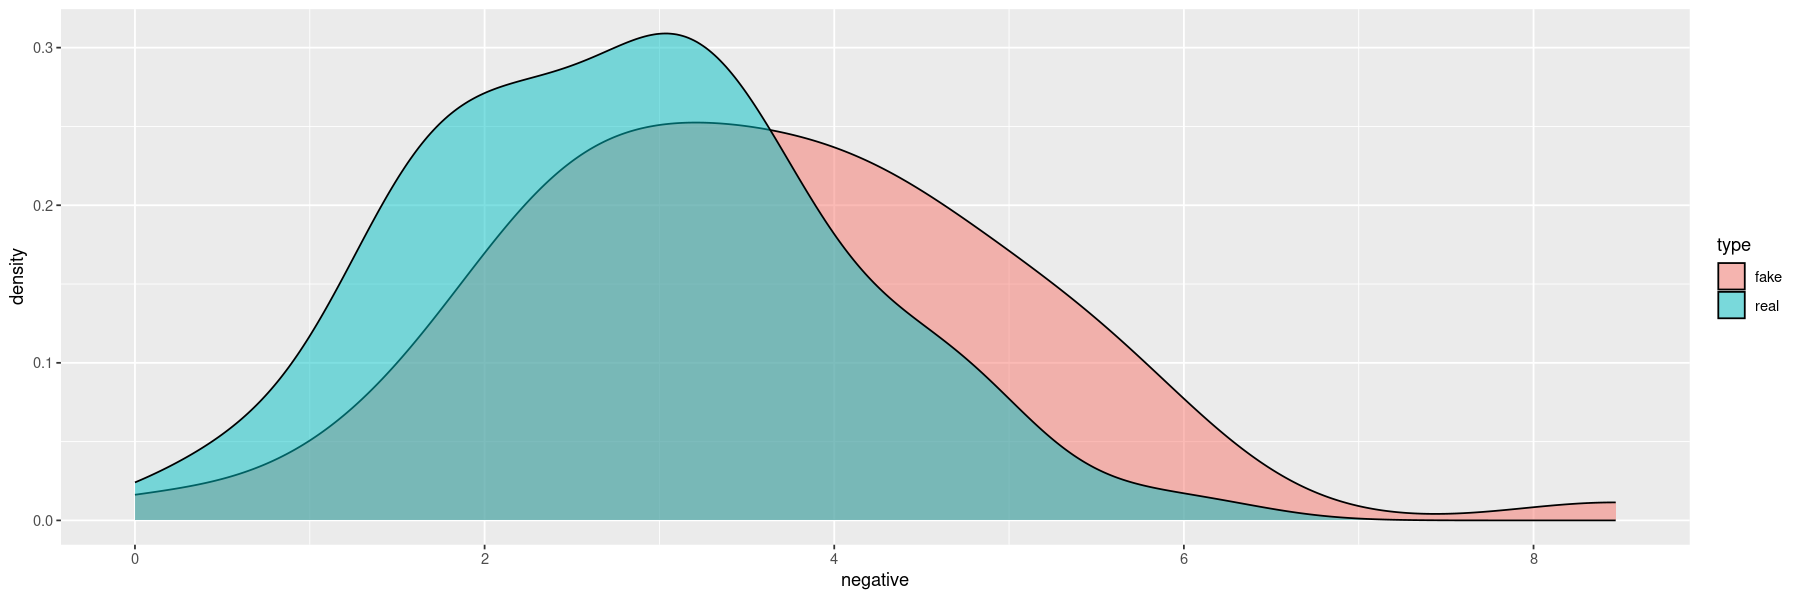

In [72]:
ggplot( data=fake_news ) + geom_density( aes(x=negative, fill=type), alpha=0.5 )

Fake news convey more often words with a negative sentiment.

### Specify prior for intercept

Expect around 40% of fake news, but could also reasonably be between 10-90%.

In [73]:
log(0.4/(1-0.4))

[1] -0.4054651

In [74]:
log(0.1/(1-0.1))

[1] -2.197225

In [75]:
log(0.9/(1-0.9))

[1] 2.197225

The uncertainty in prior odds is reflected with the following normal distribution:

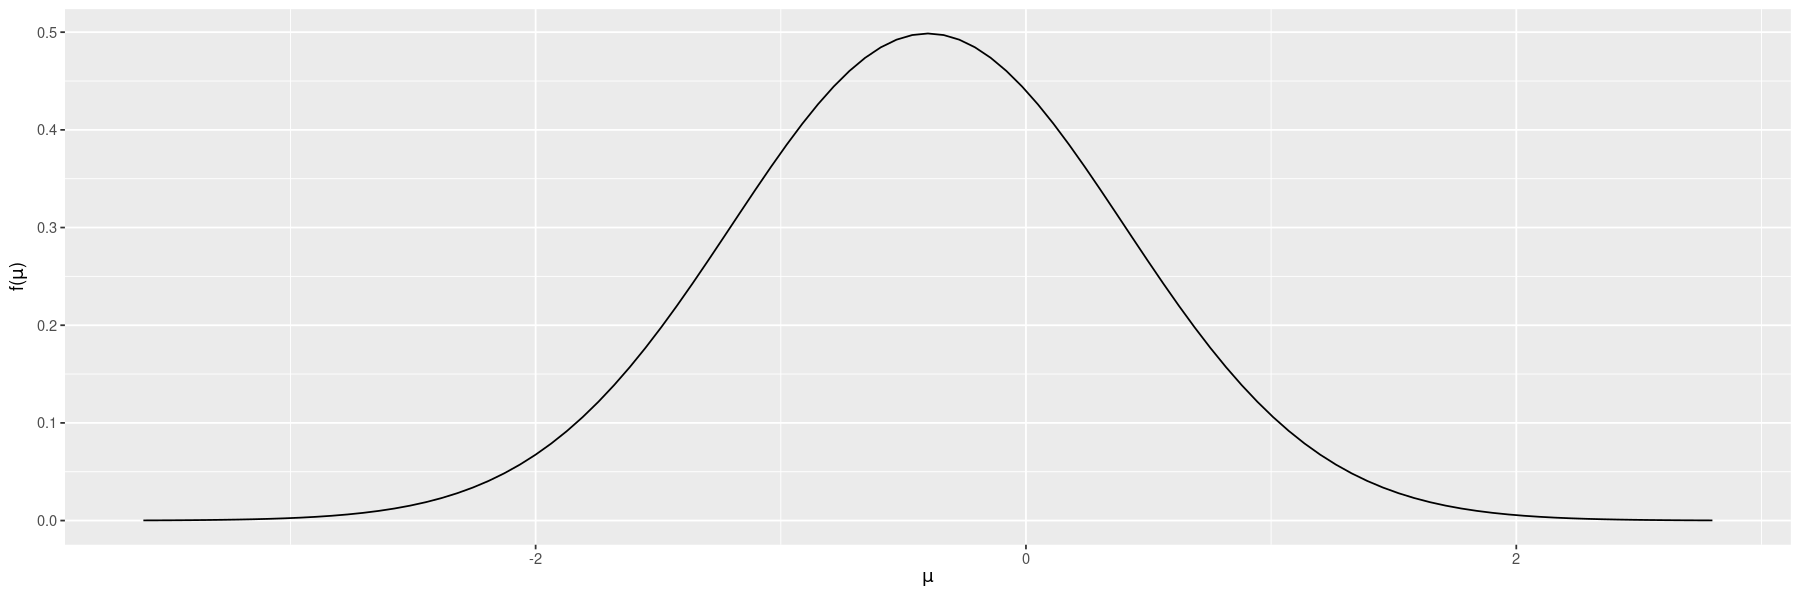

In [76]:
plot_normal( mean=-0.4, sd=0.8 )

### Simulate posterior

In [77]:
fake_news <- fake_news %>% 
    mutate( is_fake=as.numeric(type=="fake") ) %>% 
    select( -type )

In [78]:
fake_model_1 <- stan_glm( is_fake ~ title_has_excl + title_words + negative,
                             data = fake_news, family = binomial,
                             prior_intercept = normal(-0.4, 0.8),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.120301 seconds (Warm-up)
Chain 1:                0.139981 seconds (Sampling)
Chain 1:  

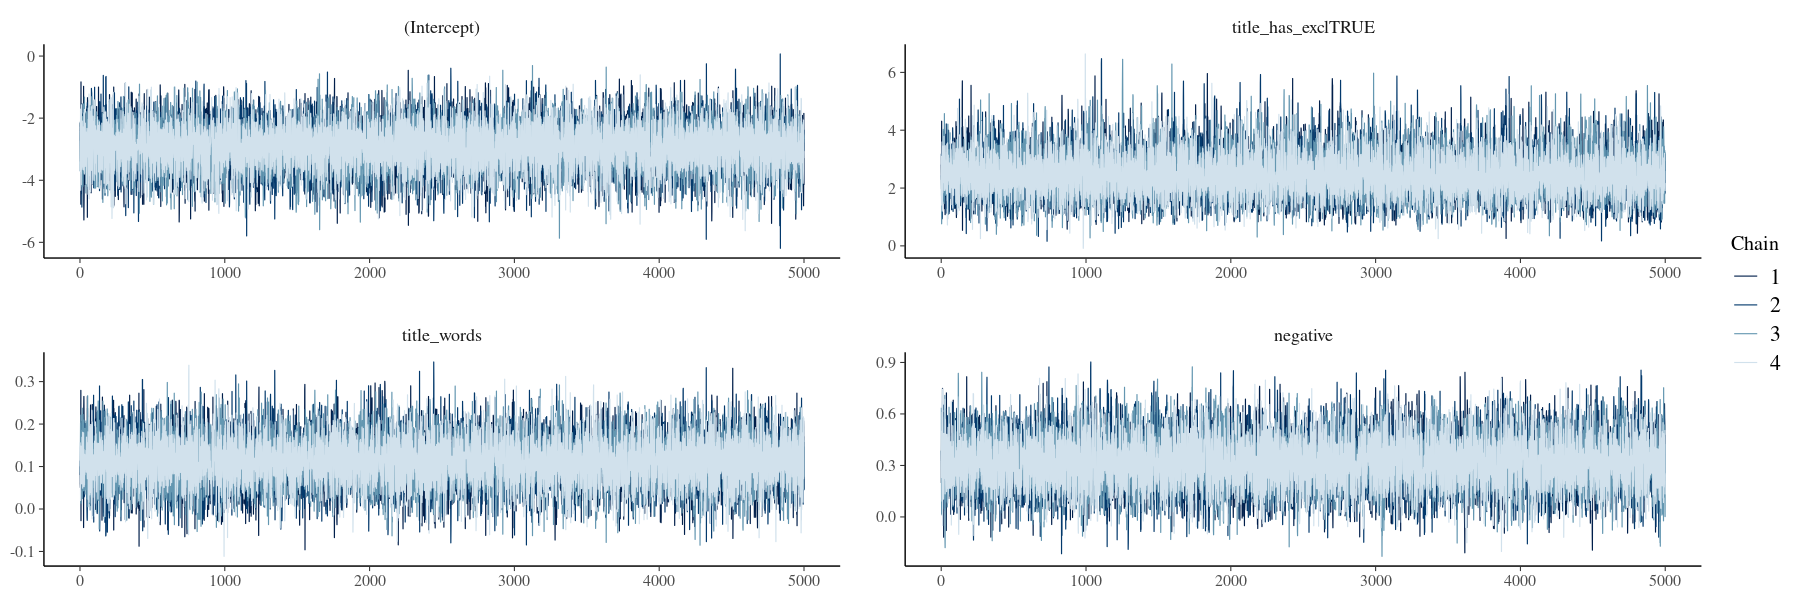

In [79]:
mcmc_trace( fake_model_1 )

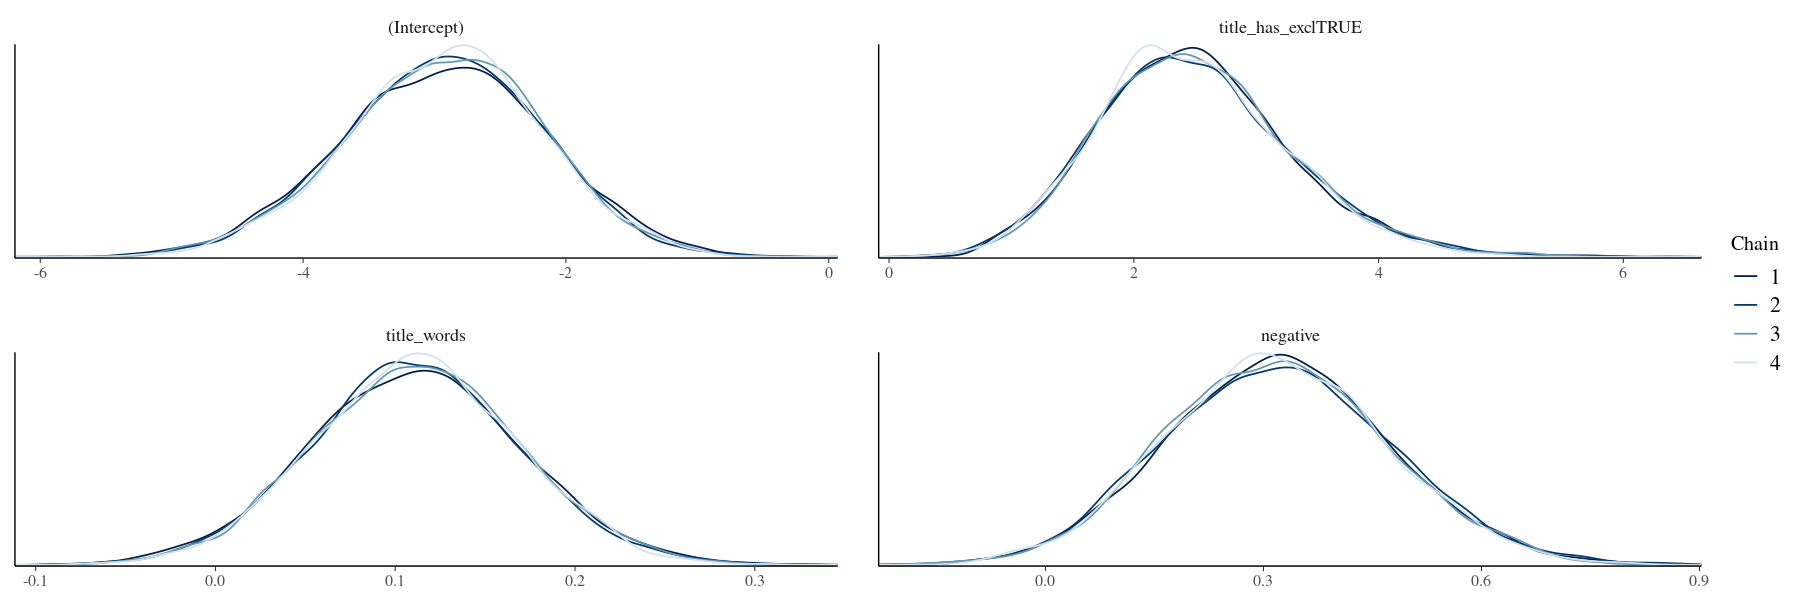

In [80]:
mcmc_dens_overlay( fake_model_1 )

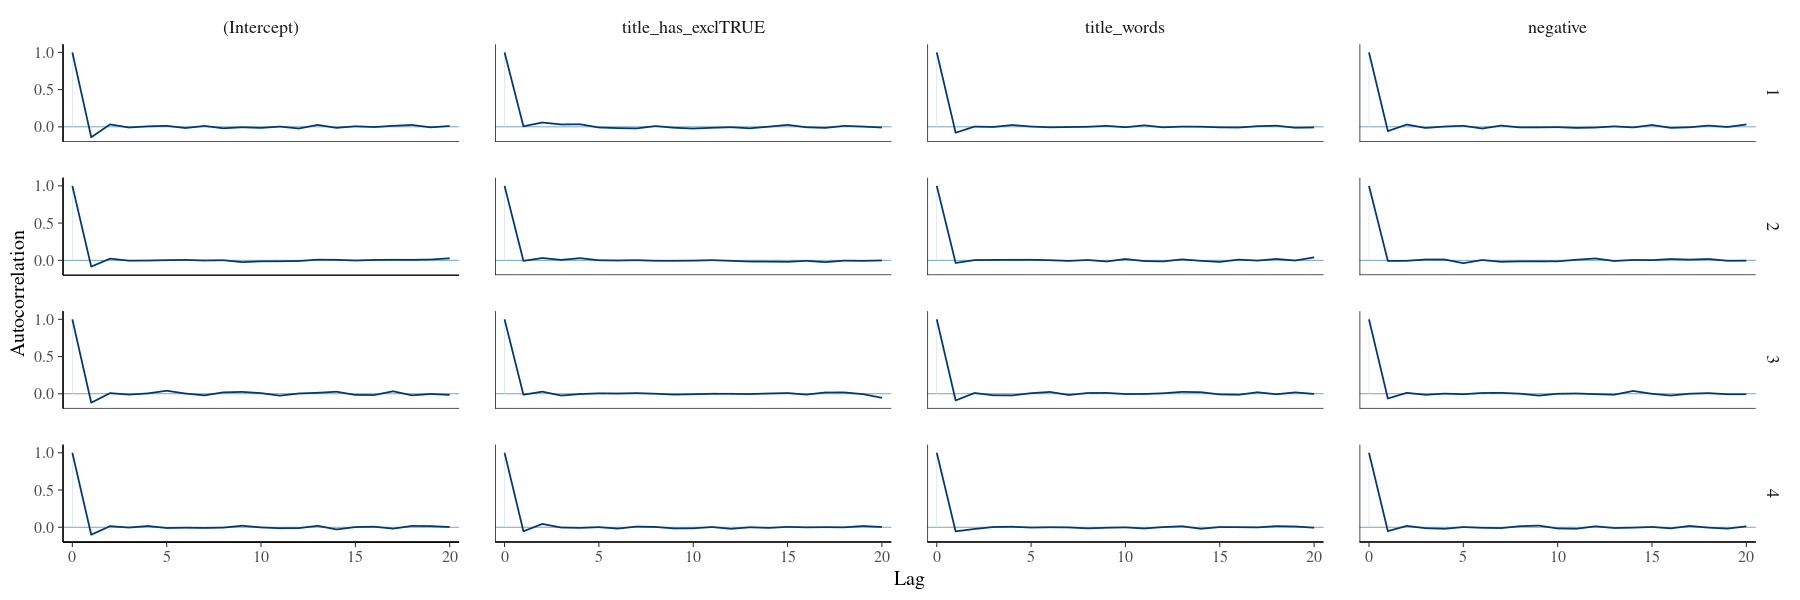

In [81]:
mcmc_acf( fake_model_1 )

### Posterior predictive check

Warning message:
“'nreps' is ignored for this PPC”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


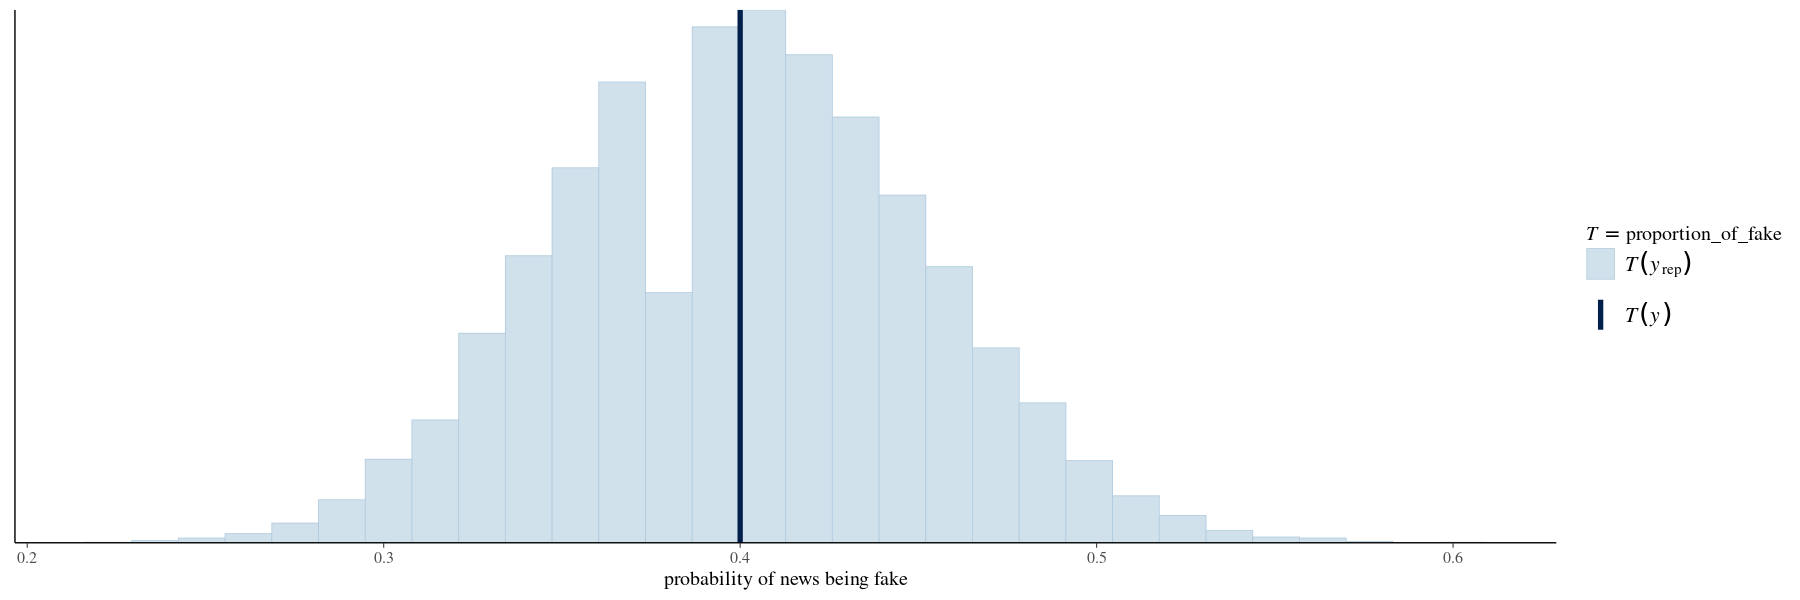

In [82]:
proportion_of_fake <- function(x){mean(x == 1)}
pp_check(fake_model_1, nreps = 100,
         plotfun = "stat", stat = "proportion_of_fake") + xlab("probability of news being fake")

The posterior distribution was narrowed down quite a bit!

### Parameter ranges

In [83]:
tidy(fake_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term               estimate   std.error  conf.low     conf.high 
1 (Intercept)        -2.9075219 0.75951530 -4.452530849 -1.4716072
2 title_has_exclTRUE  2.4434688 0.75895334  1.107301202  4.2078433
3 title_words         0.1113220 0.05745054 -0.002195581  0.2253234
4 negative            0.3178338 0.15404234  0.028119176  0.6258343

The number of words in the title appears not to be significant at the 95%-level.

#### Exclamation mark

In [84]:
c( exp(1.11), exp(2.44), exp(4.21) )

[1]  3.034358 11.473041 67.356540

If an exclamation mark is present, the odds for the news being fake increase by a factor between 3 and 67, centered at 11. This is quite a big range, more data are needed here.

#### Number of words in title

In [85]:
c( exp(-0.00022), exp(0.11), exp(0.23) )

[1] 0.999780 1.116278 1.258600

For every additional word, the odds for fake news increase by a factor of 1-1.26.

#### Percent words with negative sentiment

In [86]:
c( exp(0.028), exp(0.32), exp(0.63) )

[1] 1.028396 1.377128 1.877611

Each percent of words with negative sentiment increases the odds for fake news by a factor of 1.02-1.88 (2-88%).

Overall the ranges are quite wide because of the limited amount of available data.

### Performance metrics

In-sample:

In [87]:
classification_summary(model = fake_model_1, data = fake_news, cutoff = 0.5)

$confusion_matrix
 y  0  1
 0 84  6
 1 32 28

$accuracy_rates
                          
sensitivity      0.4666667
specificity      0.9333333
overall_accuracy 0.7466667

CV:

In [88]:
cv_accuracy <- classification_summary_cv(model = fake_model_1, data = fake_news, cutoff = 0.5, k = 10)
cv_accuracy$cv

sensitivity specificity overall_accuracy
1 0.3400397   0.9386111   0.7

Sensitivity, specificity and accuracy vary quite a bit!

In [89]:
cv_accuracy$folds

fold sensitivity specificity overall_accuracy
1   1   0.6666667   0.8888889   0.8000000       
2   2   0.2000000   0.9000000   0.6666667       
3   3   0.0000000   0.8888889   0.5333333       
4   4   0.0000000   0.9166667   0.7333333       
5   5   0.4444444   1.0000000   0.6666667       
6   6   0.2857143   1.0000000   0.6666667       
7   7   0.6666667   0.9166667   0.8666667       
8   8   0.4285714   0.8750000   0.6666667       
9   9   0.3750000   1.0000000   0.6666667       
10 10   0.3333333   1.0000000   0.7333333

Using a smaller K (K=10 means only 15 data points for hold-out set, use rather K=5 with 30 points):

In [90]:
cv_accuracy2 <- classification_summary_cv(model = fake_model_1, data = fake_news, cutoff = 0.5, k = 5)
cv_accuracy2$cv

sensitivity specificity overall_accuracy
1 0.467094    0.9345472   0.7466667

In [91]:
cv_accuracy2$folds

fold sensitivity specificity overall_accuracy
1 1    0.5833333   0.9444444   0.8000000       
2 2    0.4444444   0.9047619   0.7666667       
3 3    0.5384615   0.9411765   0.7666667       
4 4    0.3076923   0.9411765   0.6666667       
5 5    0.4615385   0.9411765   0.7333333

sensitivity, specificity and accuracy are varying less, but still quite a bit.

## Exercise 13.14

### Select some interesting predictors that might correlate with believing in ghosts

In [92]:
pulse_data <- pulse_of_the_nation %>% 
    select( ghosts, income, age, education, science_is_honest, trump_approval )
head( pulse_data )

ghosts income age education      science_is_honest trump_approval     
1 Yes      8    64  College degree Strongly Agree    Strongly disapprove
2 No      68    56  High school    Somewhat Agree    Strongly disapprove
3 No      46    63  Some college   Somewhat Agree    Somewhat Approve   
4 No      51    48  High school    Somewhat Disagree Strongly Approve   
5 Yes    100    32  Some college   Strongly Agree    Somewhat Approve   
6 No      54    64  Some college   Strongly Agree    Strongly disapprove

### Exploratory Data Analysis

#### Income

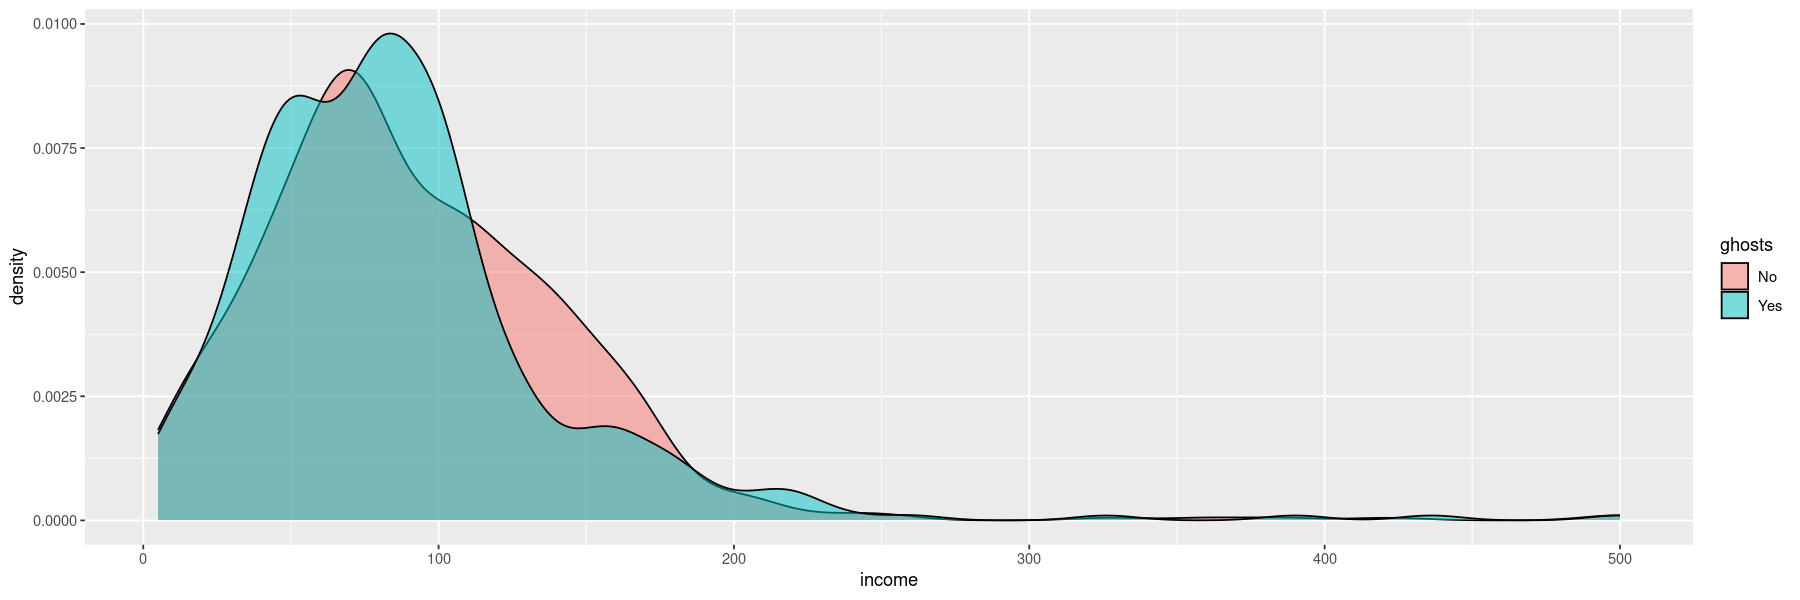

In [93]:
ggplot( pulse_data ) + geom_density( aes(x=income, fill=ghosts), alpha=0.5 )

no obvious correlations, mabye people with medium incomes believe less in ghosts.

#### Age

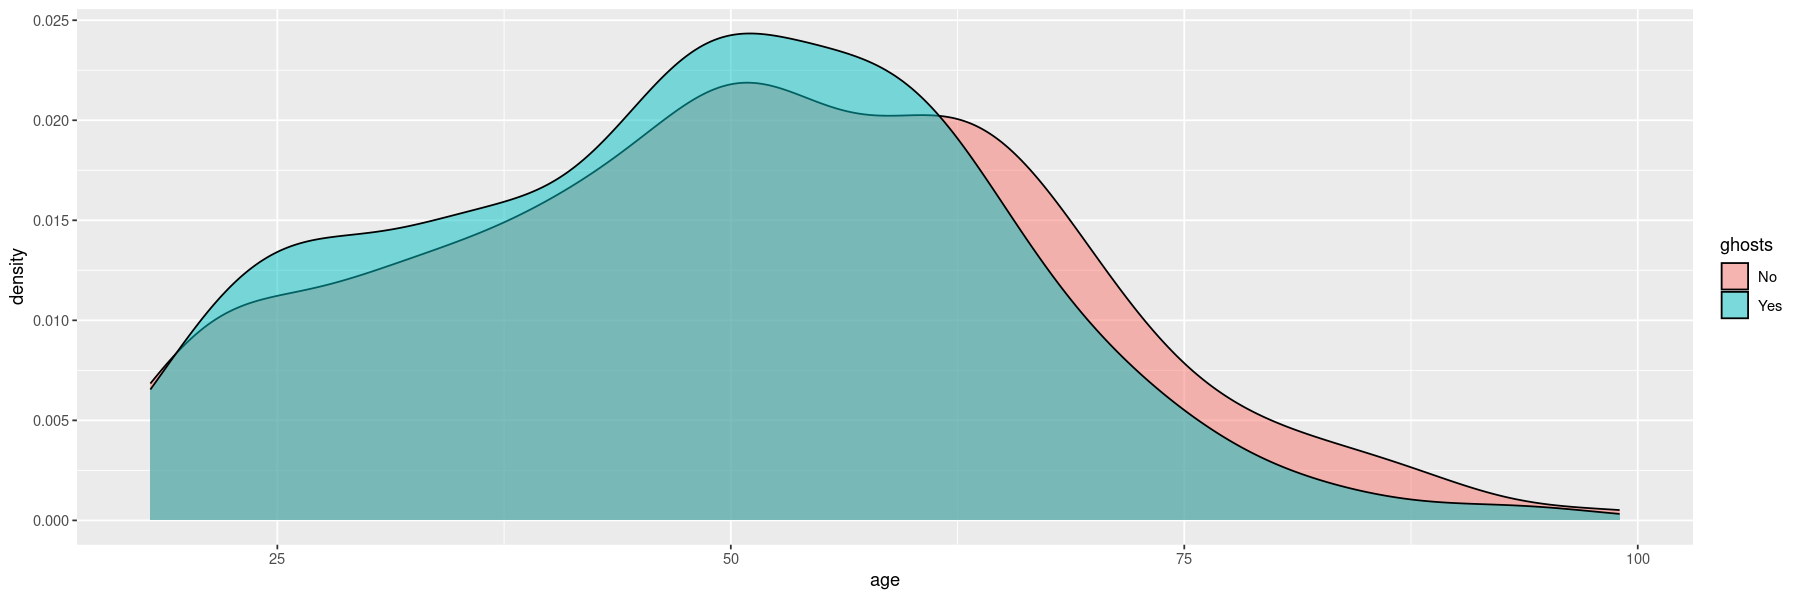

In [94]:
ggplot( pulse_data ) + geom_density( aes(x=age, fill=ghosts), alpha=0.5 )

No obvious correlations, older people appear to believe even so slightly more in ghosts.

#### Education

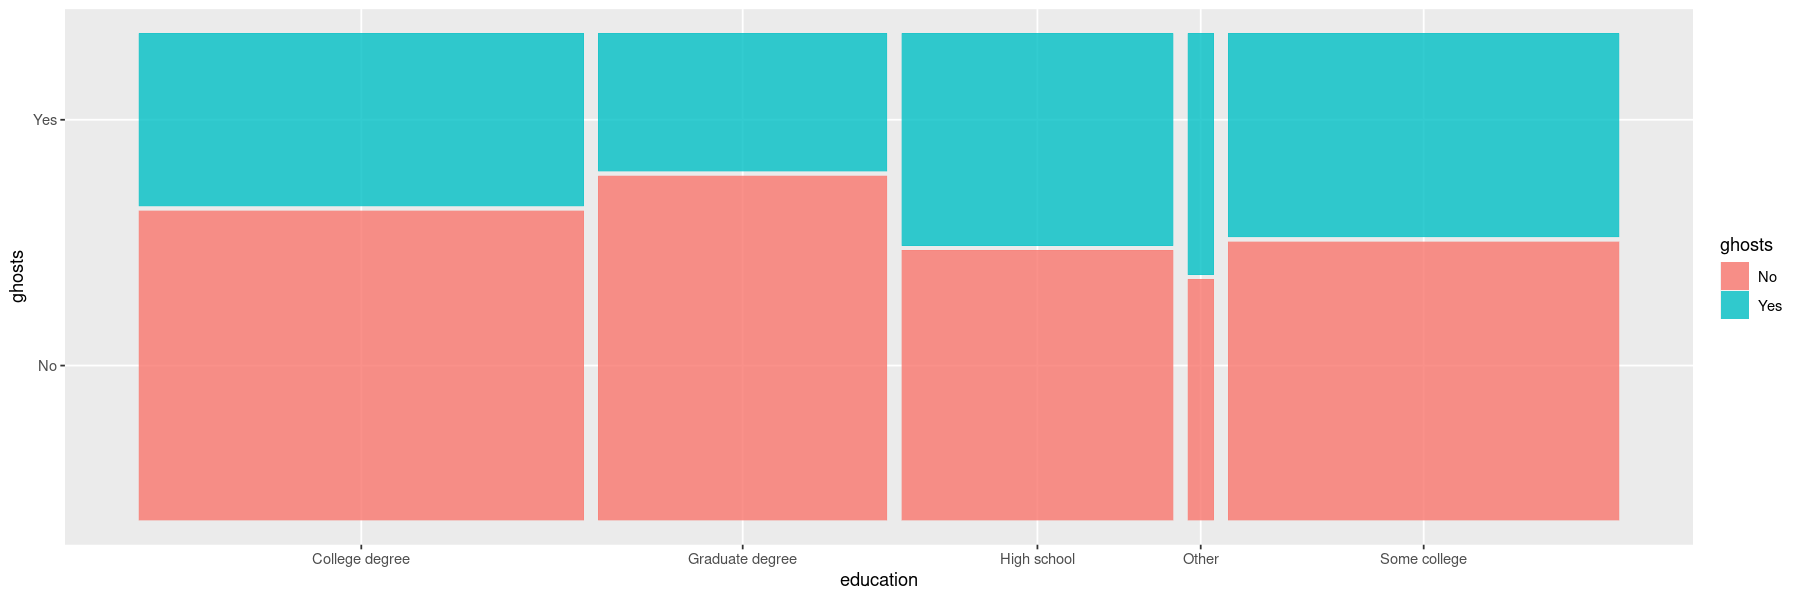

In [95]:
ggplot( pulse_data ) + geom_mosaic( aes(x=product(ghosts, education), fill=ghosts) )

There appears to be a slight correlation between believing in ghosts and education, however not as strong as suspected.

#### Science is honest

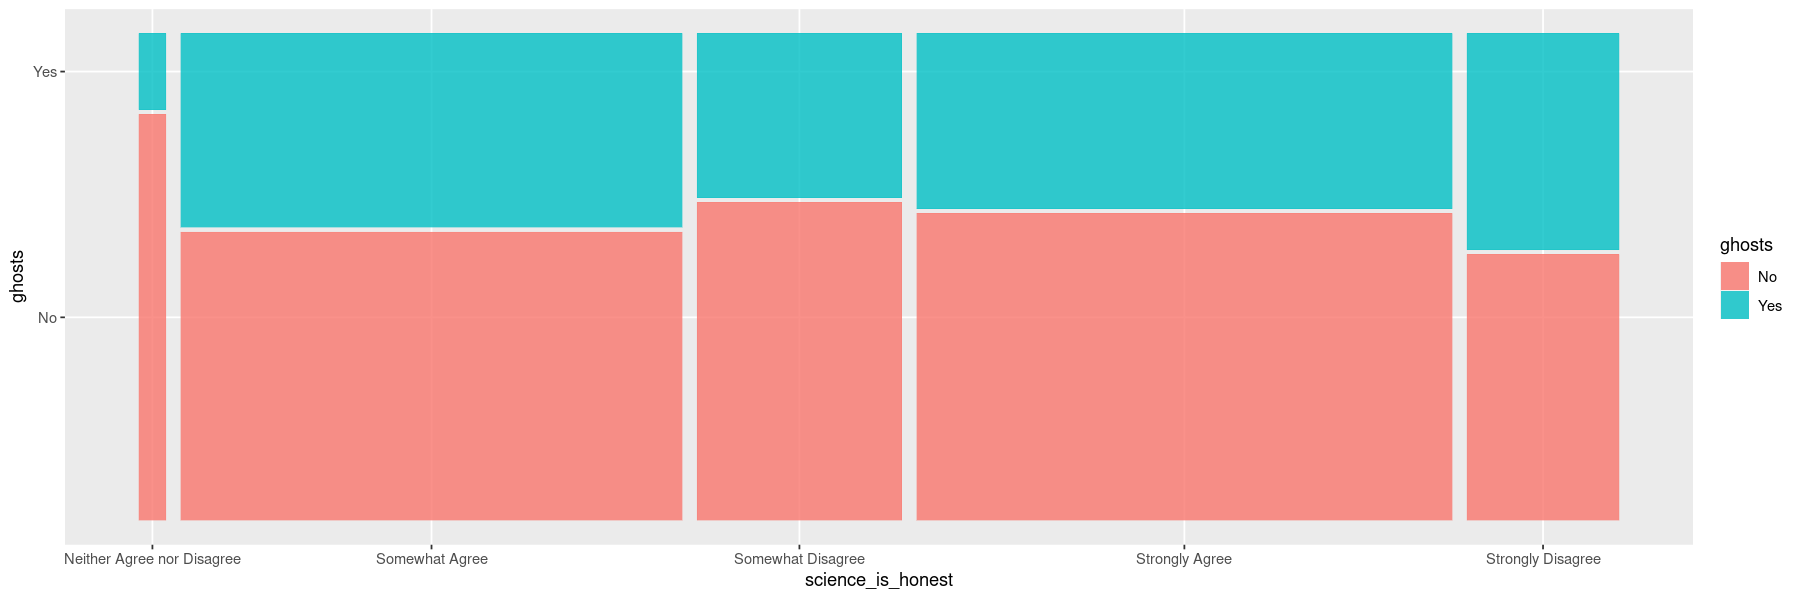

In [96]:
ggplot( pulse_data ) + geom_mosaic( aes(x=product(ghosts, science_is_honest), fill=ghosts) )

Very small differences, probably not significant.

#### Trump approval

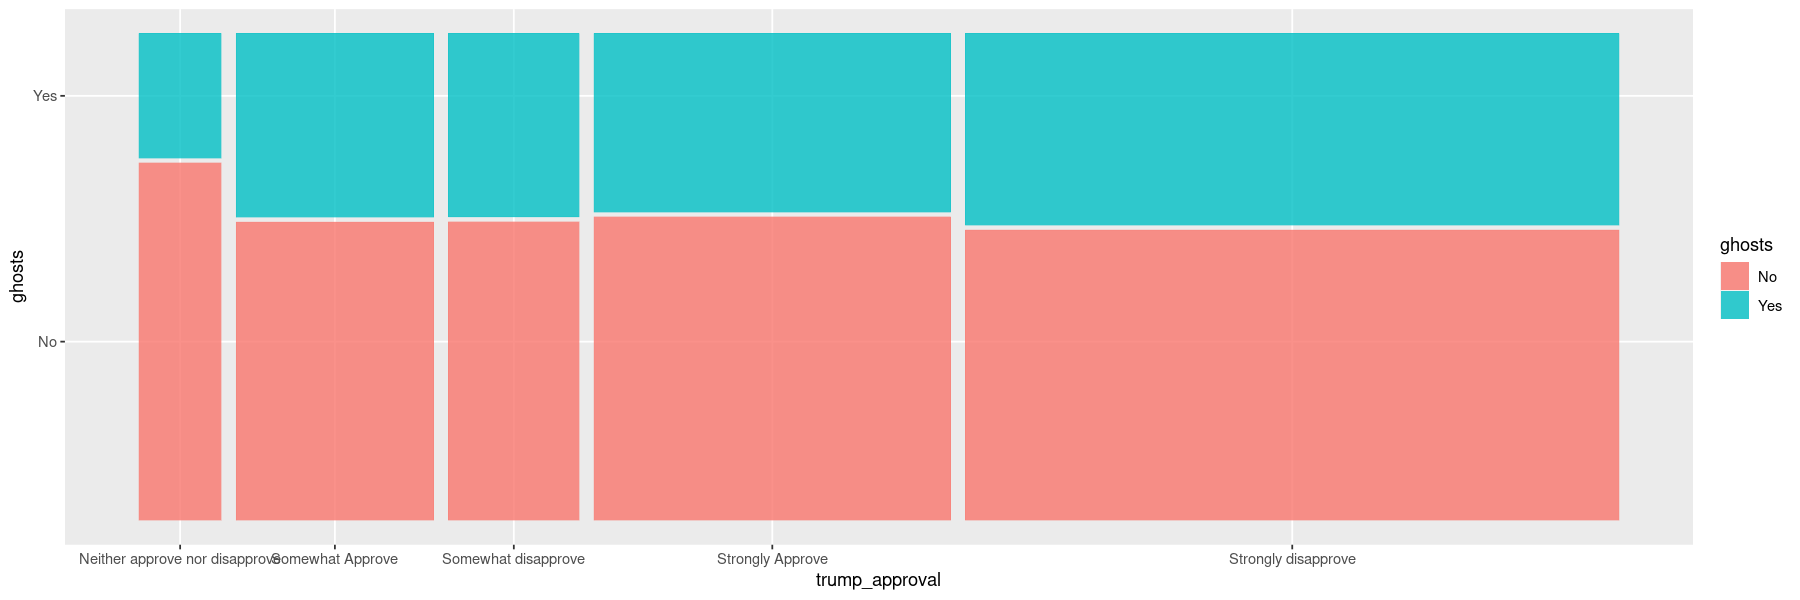

In [97]:
ggplot( pulse_data ) + geom_mosaic( aes(x=product(ghosts, trump_approval), fill=ghosts) )

Also here probably not significant.

### Specify prior for intercept

Expect around 60% who believe in ghosts, but could also reasonably be between 20-90%.

In [98]:
log(0.6/(1-0.6))

[1] 0.4054651

In [99]:
log(0.2/(1-0.2))

[1] -1.386294

In [100]:
log(0.9/(1-0.9))

[1] 2.197225

The uncertainty in prior odds is more or less reflected with the following normal distribution:

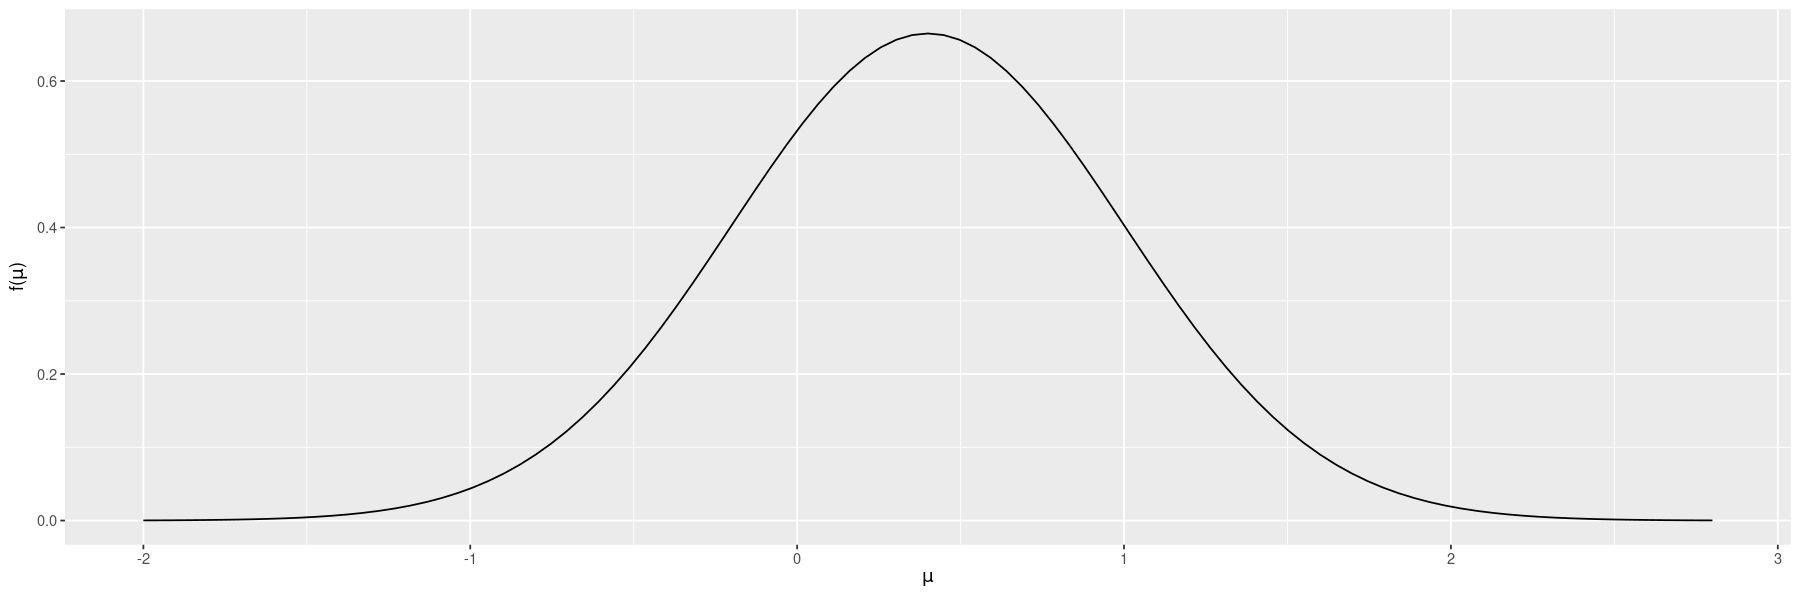

In [101]:
plot_normal( mean=0.4, sd=0.6 )

### Simulate posterior

In [102]:
pulse_data <- pulse_data %>% 
    mutate( ghosts=as.numeric(ghosts=="Yes") )

In [103]:
pulse_model_1 <- stan_glm( ghosts ~ age + income + education + science_is_honest + trump_approval,
                             data = pulse_data, family = binomial,
                             prior_intercept = normal(0.4, 0.6),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.80784 seconds (Warm-up)
Chain 1:                2.69246 seconds (Sampling)
Chain 1:    

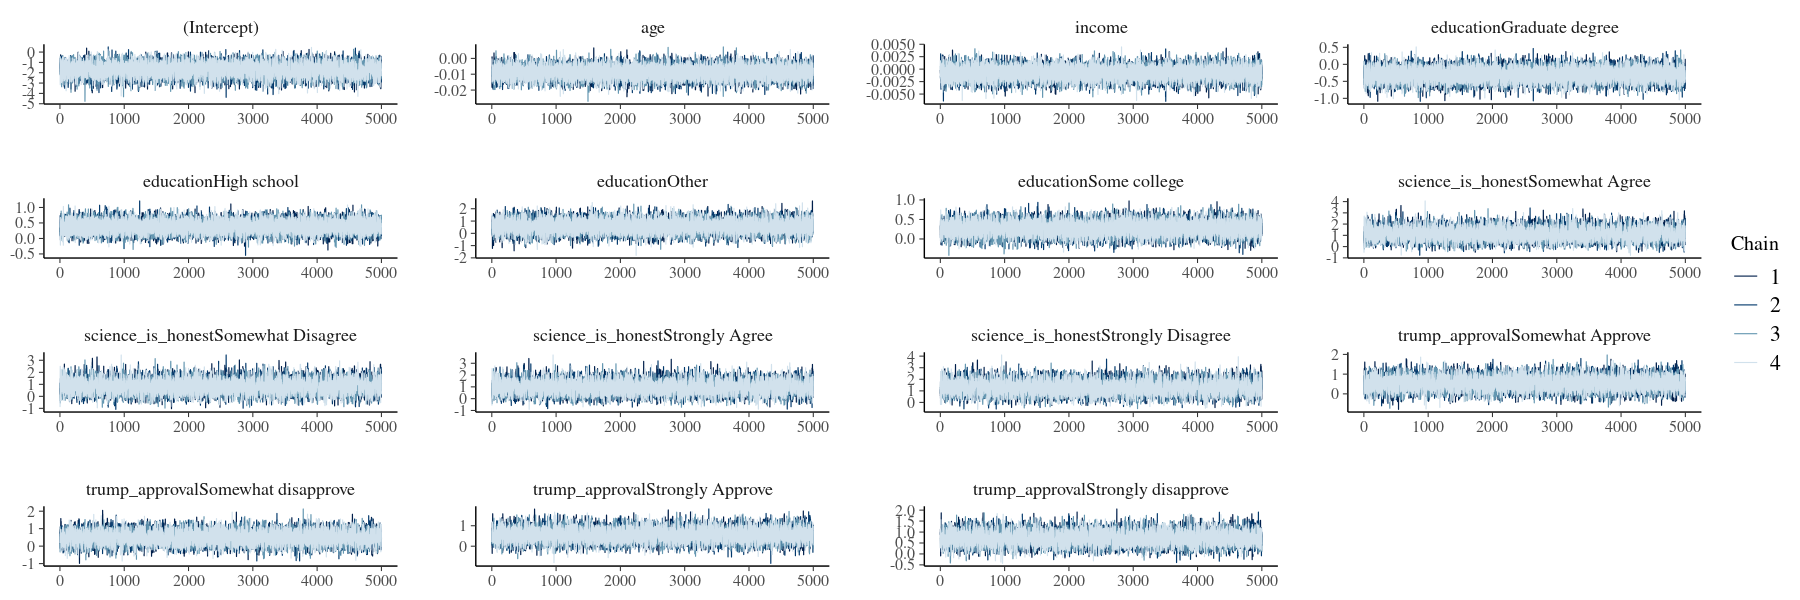

In [104]:
mcmc_trace( pulse_model_1 )

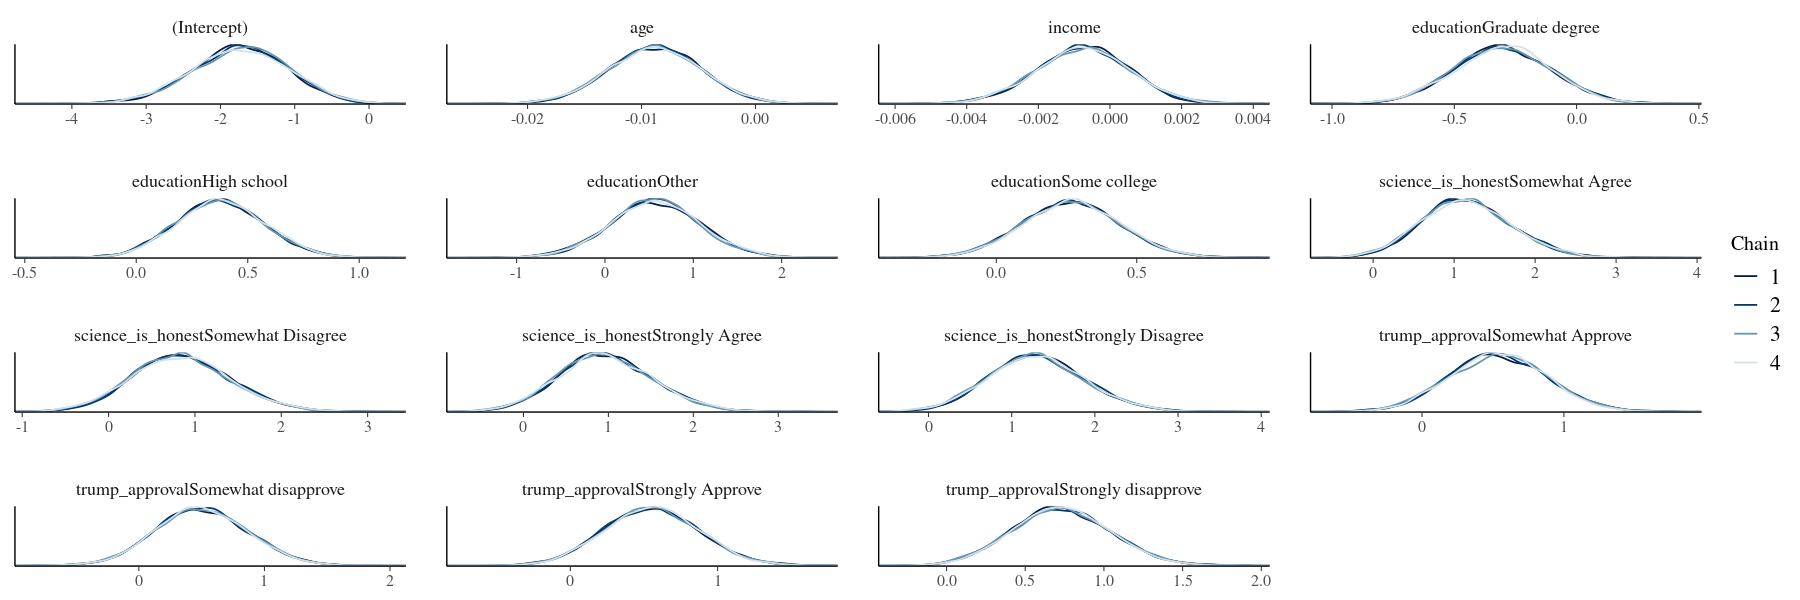

In [105]:
mcmc_dens_overlay( pulse_model_1 )

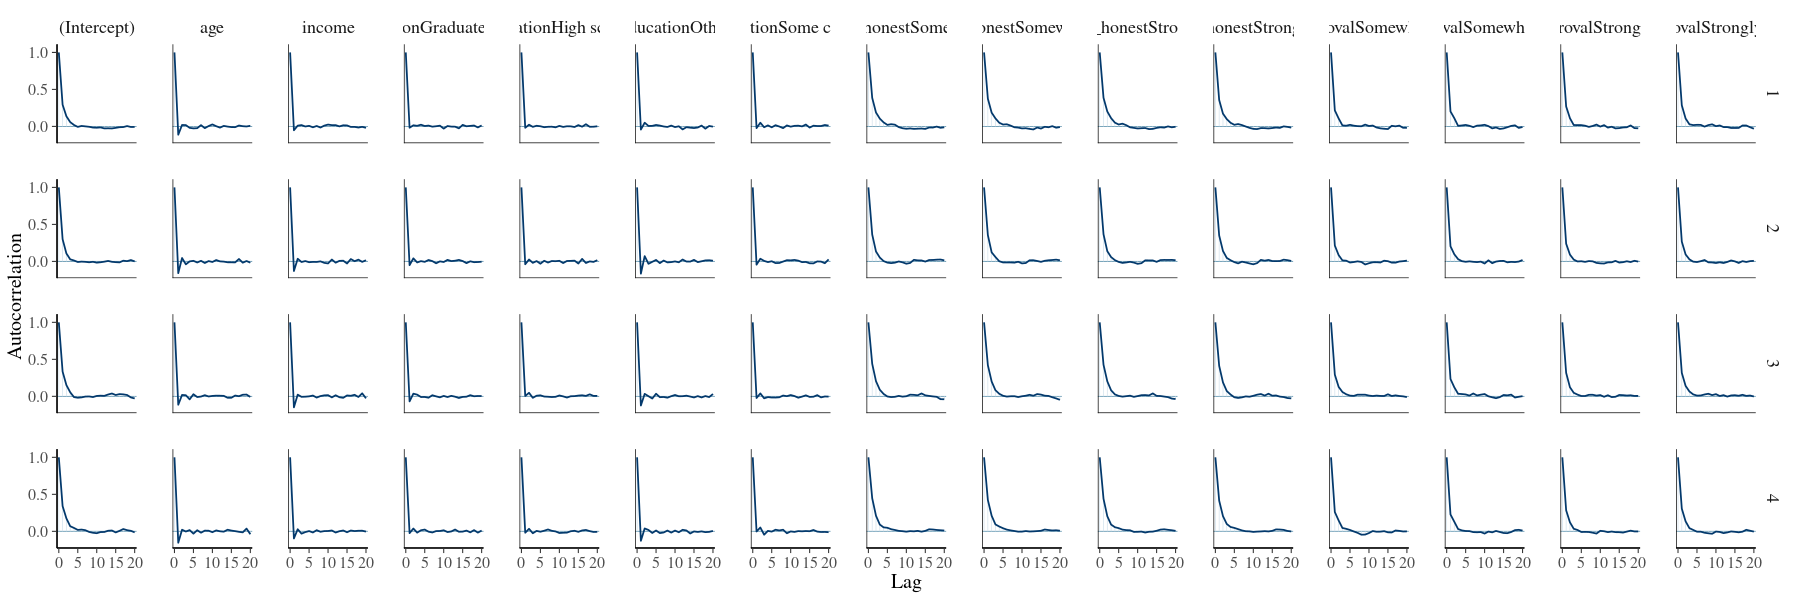

In [106]:
mcmc_acf( pulse_model_1 )

### Posterior predictive check

Warning message:
“'nreps' is ignored for this PPC”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


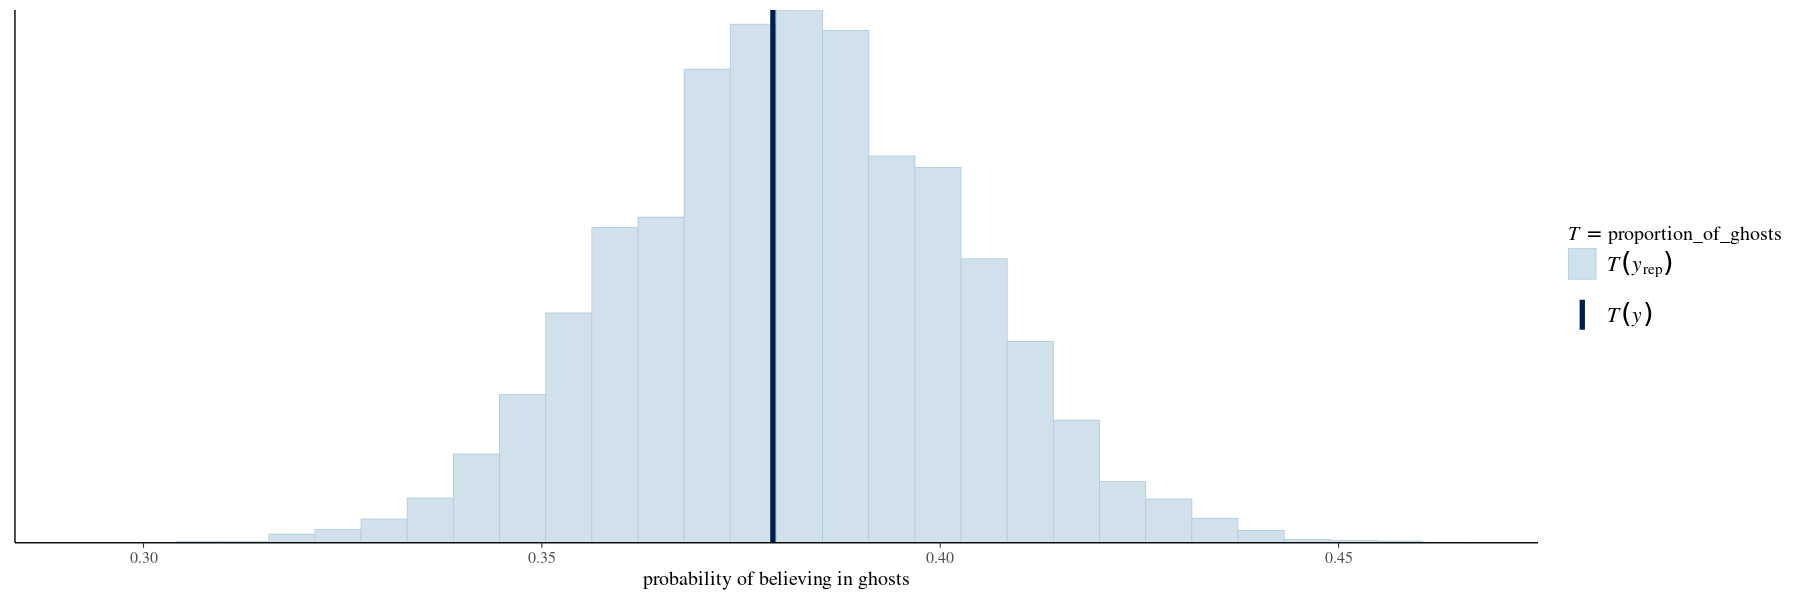

In [107]:
proportion_of_ghosts <- function(x){mean(x == 1)}
pp_check(pulse_model_1, nreps = 100,
         plotfun = "stat", stat = "proportion_of_ghosts") + xlab("probability of believing in ghosts")

### Parameter ranges

In [108]:
tidy(pulse_model_1, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term                               estimate      std.error   conf.low    
1  (Intercept)                        -1.7272156368 0.649998894 -3.057031004
2  age                                -0.0087975842 0.004071164 -0.016826448
3  income                             -0.0007426599 0.001290706 -0.003374491
4  educationGraduate degree           -0.3036828995 0.198303966 -0.688425521
5  educationHigh school                0.3753208081 0.196722888 -0.001248007
6  educationOther                      0.5684712488 0.500754317 -0.445618556
7  educationSome college               0.2669902207 0.174887687 -0.072274375
8  science_is_honestSomewhat Agree     1.1356768450 0.544904000  0.107309155
9  science_is_honestSomewhat Disagree  0.8360796514 0.568171033 -0.232795020
10 science_is_honestStrongly Agree     0.9541872485 0.552602988 -0.068699415
11 science_is_honestStrongly Disagree  1.2913664396 0.573804169  0.217174697
12 trump_approvalSomewhat Approve      0.5323032328 0.346767339 -0.122920153
13 trump_approvalSomewhat disapprove   0.4953353137 0.368243727 -0.207054762
14 trump_approvalStrongly Approve      0.5526476714 0.327415250 -0.068107641
15 trump_approvalStrongly disapprove   0.7249495652 0.311730683  0.128547244
   conf.high    
1  -0.5112633730
2  -0.0008942501
3   0.0017734899
4   0.0848380810
5   0.7708382558
6   1.5956771172
7   0.6153956820
8   2.2914345614
9   2.0257495431
10  2.1235345838
11  2.4911675867
12  1.2204693874
13  1.2346362902
14  1.2005745420
15  1.3608364941

Significant at 95%-level: age, trump_approval: strongly disapprove, science_is_honest: somewhat agree, strongly disagree

Not significant: income, education, trump_approval: everything except strongly disapprove, science_is_honest: everything else

It remains to be investigated whether only some values of a discrete quantity are significant.

#### Age

In [109]:
c( exp(-0.017), exp(-0.00088), exp(-0.00069) )

[1] 0.9831437 0.9991204 0.9993102

Even though the relation is significant, the effective appears to be small (around 0.1% more belief in ghosts for every year of living)

#### trump approval: strongly disapprove

In [110]:
c( exp(0.13), exp(0.71), exp(1.34) )

[1] 1.138828 2.033991 3.819044

If somebody strongly disapproves of Trump, the odds that they believe in ghosts are doubled! This seems indeed to be an interesting finding..

#### science is honest: somewhat agree

In [111]:
c( exp(0.11), exp(1.14), exp(2.29) )

[1] 1.116278 3.126768 9.874938

#### science is honest: strongly disagree

In [112]:
c( exp(0.22), exp(1.29), exp(2.49) )

[1]  1.246077  3.632787 12.061276

Strong factors! Hard to say whether this is actually true.

### Simpler model?

Only use significant predictors:

In [113]:
pulse_data2 <- pulse_data %>% 
    mutate( trump_disapprove=ifelse(trump_approval=="Strongly disapprove", 1, 0)) %>% 
    mutate( science_is_honest_somewhat_agree=ifelse(science_is_honest=="Somewhat Agree", 1, 0) ) %>% 
    mutate( science_is_honest_strongly_disagree=ifelse(science_is_honest=="Strongly Disagree", 1, 0) ) %>% 
    select( ghosts, age, trump_disapprove, science_is_honest_somewhat_agree, science_is_honest_strongly_disagree )
head( pulse_data2 )

ghosts age trump_disapprove science_is_honest_somewhat_agree
1 1      64  1                0                               
2 0      56  1                1                               
3 0      63  0                1                               
4 0      48  0                0                               
5 1      32  0                0                               
6 0      64  1                0                               
  science_is_honest_strongly_disagree
1 0                                  
2 0                                  
3 0                                  
4 0                                  
5 0                                  
6 0

In [114]:
pulse_model_2 <- stan_glm( ghosts ~ age + trump_disapprove + science_is_honest_somewhat_agree + science_is_honest_strongly_disagree,
                             data = pulse_data2, family = binomial,
                             prior_intercept = normal(0.4, 0.6),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.533343 seconds (Warm-up)
Chain 1:                0.5704 seconds (Sampling)
Chain 1:    

In [115]:
tidy(pulse_model_2, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term                                estimate     std.error   conf.low   
1 (Intercept)                         -0.327064681 0.232890583 -0.78064462
2 age                                 -0.008453545 0.003948532 -0.01638031
3 trump_disapprove                     0.225655382 0.137093533 -0.03961780
4 science_is_honest_somewhat_agree     0.276340227 0.145920437 -0.01127357
5 science_is_honest_strongly_disagree  0.494714718 0.223413631  0.06069460
  conf.high   
1  0.129366642
2 -0.000616473
3  0.488840621
4  0.557672279
5  0.930210683

Now only science is honest strongly disagree and age are significant..

Third and simplest model:

In [116]:
pulse_model_3 <- stan_glm( ghosts ~ age + science_is_honest_strongly_disagree,
                             data = pulse_data2, family = binomial,
                             prior_intercept = normal(0.4, 0.6),
                             prior = normal(0, 1, autoscale=TRUE),
                             chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.429696 seconds (Warm-up)
Chain 1:                0.501295 seconds (Sampling)
Chain 1:     

### Performance metrics

CV (use 5 folds for efficiency):

In [117]:
cv_accuracy1 <- classification_summary_cv(model = pulse_model_1, data = pulse_data, cutoff = 0.5, k = 5)
cv_accuracy1$cv

sensitivity specificity overall_accuracy
1 0.09386942  0.9055878   0.597

In [118]:
cv_accuracy2 <- classification_summary_cv(model = pulse_model_2, data = pulse_data2, cutoff = 0.5, k = 5)
cv_accuracy2$cv

sensitivity specificity overall_accuracy
1 0.0408025   0.9750452   0.62

In [119]:
cv_accuracy3 <- classification_summary_cv(model = pulse_model_3, data = pulse_data2, cutoff = 0.5, k = 5)
cv_accuracy3$cv

sensitivity specificity overall_accuracy
1 0.01606765  0.9857816   0.618

It appears to be difficult to compare the three models. While model 2 and 3 are very similar, model 1 appears to have a larger sensitivity at the cost of a lower specificity and at a similar accuracy.